In [29]:
import sys
import numpy as np
import pandas as pd
import sklearn, matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import catboost, xgboost, lightgbm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from scipy import interp
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split , StratifiedKFold
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from scipy import interp

print('python',sys.version[0:6])
print('pandas',pd.__version__)
print('sklearn',sklearn.__version__)
print('numpy',np.__version__)
print('matplotlib',matplotlib.__version__)
print('seaborn',sns.__version__)
print('catboost',catboost.__version__)
print('xgboost',xgboost.__version__)
print('lightgbm',lightgbm.__version__)
print('tensorflow',tf.__version__)
print('keras',keras.__version__)

python 3.6.12
pandas 0.25.3
sklearn 0.22.1
numpy 1.18.1
matplotlib 3.1.3
seaborn 0.10.0
catboost 0.22
xgboost 1.0.0
lightgbm 2.3.1
tensorflow 2.1.0
keras 2.3.1


In [30]:
pd.options.display.max_rows =250
pd.options.display.max_columns =250

In [31]:
label=pd.read_csv('samp_train.csv')
train=pd.read_csv('samp_cst_feat.csv')

* 데이터양에 비해 컬럼수가 많음 > 차원축소 고려?
* 특정 label에 쏠려있음 > auroc점수 계산 및 imbalanced 문제 해결법 고려

# preprocessing

In [32]:
display(label,train)

,cst_id_di,MRC_ID_DI
0,90000000089,0
1,90000000176,8
2,90000000210,0
3,90000000212,5
4,90000000213,6
...,...,...
10119,90000460112,7
10120,90000460117,0
10121,90000460233,0
10122,90000460310,0


,cst_id_di,VAR002,VAR003,VAR004,VAR005,VAR006,VAR007,VAR008,VAR009,VAR010,VAR011,VAR012,VAR013,VAR014,VAR015,VAR016,VAR017,VAR018,VAR019,VAR020,VAR021,VAR022,VAR023,VAR024,VAR025,VAR026,VAR027,VAR028,VAR029,VAR030,VAR031,VAR032,VAR033,VAR034,VAR035,VAR036,VAR037,VAR038,VAR039,VAR040,VAR041,VAR042,VAR043,VAR044,VAR045,VAR046,VAR047,VAR048,VAR049,VAR050,VAR051,VAR052,VAR053,VAR054,VAR055,VAR056,VAR057,VAR058,VAR059,VAR060,VAR061,VAR062,VAR063,VAR064,VAR065,VAR066,VAR067,VAR068,VAR069,VAR070,VAR071,VAR072,VAR073,VAR074,VAR075,VAR076,VAR077,VAR078,VAR079,VAR080,VAR081,VAR082,VAR083,VAR084,VAR085,VAR086,VAR087,VAR088,VAR089,VAR090,VAR091,VAR092,VAR093,VAR094,VAR095,VAR096,VAR097,VAR098,VAR099,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,VAR150,VAR151,VAR152,VAR153,VAR154,VAR155,VAR156,VAR157,VAR158,VAR159,VAR160,VAR161,VAR162,VAR163,VAR164,VAR165,VAR166,VAR167,VAR168,VAR169,VAR170,VAR171,VAR172,VAR173,VAR174,VAR175,VAR176,VAR177,var178,VAR179,VAR180,VAR181,VAR182,VAR183,VAR184,VAR185,VAR186,VAR187,VAR188,VAR189,VAR190,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200,VAR201,VAR202,VAR203,VAR204,VAR205,VAR206,VAR207,VAR208,VAR209,VAR210,VAR211,VAR212,VAR213,VAR214,VAR215,VAR216,VAR217,VAR218,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227
0,90000000089,-0.06610,0.5280,-0.13607,0.10945,0.06557,0,0.7702,-0.18965,0.1981,0.24149,0.32429,-0.18611,0.06960,1,0.0049,0.8085,0,-0.11899,0.03969,-0.16651,0.12037,-0.01715,-0.09941,-0.28878,0,-0.07481,-0.12742,0.14367,0.06725,0.7702,0.04138,-0.01619,-0.32429,0.11580,0.7179,0.16920,-0.08048,0.28126,-0.11289,-0.02092,0.5381,0.22047,0.17756,0.03794,-0.04432,-0.28743,-0.01164,0.26300,-0.15466,-0.08374,-0.12935,-0.24726,-0.32134,0.39311,-0.32813,0.35632,0.12739,1,-0.18338,-0.07717,0.4688,0.18707,-0.03818,-0.04869,1,1,-0.14361,0.20281,0,0,0.02536,-0.20705,0.03747,0.28517,-0.18100,0,0,-0.20069,0.23156,-0.18709,0.20059,0.04329,0.0025,0.13105,-0.00891,0.23236,0.10216,0.28202,0.0077,-0.09886,0.29902,-0.22713,0,-0.23064,0,0,0,0.06628,0.11613,0.0093,0.03583,0.3578,0.20585,1.0000,-0.29631,0,0.0008,0.26873,0.05674,0,0.02082,0.26616,-0.25601,0.16075,0.15089,0.7286,0.07524,-0.11761,-0.13649,0.16103,0.38476,0.18881,0,0.00524,0.29896,1,0.36885,0.05585,0.06960,0.0068,0.05439,-0.04895,0.22997,0.06607,-0.02500,-0.05500,0.0020,0.07158,-0.11915,-0.09522,0.11580,1,0,0,0.35606,-0.32429,0,0.19451,-0.22885,0.01926,-0.15068,0.13834,-0.16525,0.09025,0.01253,0.20219,0.31263,-0.17855,-0.20515,-0.18453,-0.21851,0.37549,-0.10744,0,0.13043,0.0013,-0.17485,0.18986,-0.07305,0.0069,-0.30157,-0.16382,0.28385,-0.14273,-0.27069,0,0.3766,0,0.06165,0.0021,-0.03891,0.04840,-0.14790,0.26533,-0.00426,0.14765,-0.13332,0.03077,0.23017,0.11764,0.5740,0.06403,0.06184,0.04242,-0.04322,0.0051,0.04523,0,0.07247,0.09631,-0.22864,0.07262,-0.08837,0.01070,0.06340,0.12424,0,0.20392,0.24685,0.01432,-0.00966,0.09746,-0.17616,-0.18956,-0.13676,-0.13279,-0.32829,0.19113,0.05449,0.09471,0.27091,0.01931,0.02938,0.17105,0.12537,0.22197
1,90000000176,-0.09537,0.1347,-0.13541,0.17331,-0.19657,0,0.0616,-0.23104,0.4940,-0.39476,-0.38366,0.39329,0.17549,0,0.3130,0.6564,0,0.31544,0.03794,-0.30237,-0.34538,0.04368,0.04381,-0.19160,0,-0.09801,-0.04593,0.11228,0.11692,0.5661,0.19938,0.01259,-0.17976,0.20081,0.7454,0.24256,0.01363,-0.22807,0.06728,0.17312,0.5369,0.23387,0.04572,0.05406,-0.18782,-0.23752,-0.10148,-0.16942,0.02893,0.03702,0.04855,0.36531,0.24302,-0.30677,-0.20810,-0.12376,0.15054,0,0.22430,0.10513,0.3797,-0.16796,0.01456,-0.10743,0,1,-0.08246,-0.38202,0,0,0.02066,0.28113,0.05687,-0.11689,0.16837,1,1,-0.08043,0.21618,-0.20256,0.23597,0.06233,0.3285,0.05898,0.00544,-0.29231,0.02483,-0.38122,0.0065,0.39975,0.09775,-0.34015

label과 train의 id순서가 동일한지 확인

In [33]:
(label['cst_id_di']==train['cst_id_di']).value_counts()

True    10124
Name: cst_id_di, dtype: int64

In [34]:
train['MRC_ID_DI']=label['MRC_ID_DI']
train

,cst_id_di,VAR002,VAR003,VAR004,VAR005,VAR006,VAR007,VAR008,VAR009,VAR010,VAR011,VAR012,VAR013,VAR014,VAR015,VAR016,VAR017,VAR018,VAR019,VAR020,VAR021,VAR022,VAR023,VAR024,VAR025,VAR026,VAR027,VAR028,VAR029,VAR030,VAR031,VAR032,VAR033,VAR034,VAR035,VAR036,VAR037,VAR038,VAR039,VAR040,VAR041,VAR042,VAR043,VAR044,VAR045,VAR046,VAR047,VAR048,VAR049,VAR050,VAR051,VAR052,VAR053,VAR054,VAR055,VAR056,VAR057,VAR058,VAR059,VAR060,VAR061,VAR062,VAR063,VAR064,VAR065,VAR066,VAR067,VAR068,VAR069,VAR070,VAR071,VAR072,VAR073,VAR074,VAR075,VAR076,VAR077,VAR078,VAR079,VAR080,VAR081,VAR082,VAR083,VAR084,VAR085,VAR086,VAR087,VAR088,VAR089,VAR090,VAR091,VAR092,VAR093,VAR094,VAR095,VAR096,VAR097,VAR098,VAR099,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,VAR150,VAR151,VAR152,VAR153,VAR154,VAR155,VAR156,VAR157,VAR158,VAR159,VAR160,VAR161,VAR162,VAR163,VAR164,VAR165,VAR166,VAR167,VAR168,VAR169,VAR170,VAR171,VAR172,VAR173,VAR174,VAR175,VAR176,VAR177,var178,VAR179,VAR180,VAR181,VAR182,VAR183,VAR184,VAR185,VAR186,VAR187,VAR188,VAR189,VAR190,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200,VAR201,VAR202,VAR203,VAR204,VAR205,VAR206,VAR207,VAR208,VAR209,VAR210,VAR211,VAR212,VAR213,VAR214,VAR215,VAR216,VAR217,VAR218,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227,MRC_ID_DI
0,90000000089,-0.06610,0.5280,-0.13607,0.10945,0.06557,0,0.7702,-0.18965,0.1981,0.24149,0.32429,-0.18611,0.06960,1,0.0049,0.8085,0,-0.11899,0.03969,-0.16651,0.12037,-0.01715,-0.09941,-0.28878,0,-0.07481,-0.12742,0.14367,0.06725,0.7702,0.04138,-0.01619,-0.32429,0.11580,0.7179,0.16920,-0.08048,0.28126,-0.11289,-0.02092,0.5381,0.22047,0.17756,0.03794,-0.04432,-0.28743,-0.01164,0.26300,-0.15466,-0.08374,-0.12935,-0.24726,-0.32134,0.39311,-0.32813,0.35632,0.12739,1,-0.18338,-0.07717,0.4688,0.18707,-0.03818,-0.04869,1,1,-0.14361,0.20281,0,0,0.02536,-0.20705,0.03747,0.28517,-0.18100,0,0,-0.20069,0.23156,-0.18709,0.20059,0.04329,0.0025,0.13105,-0.00891,0.23236,0.10216,0.28202,0.0077,-0.09886,0.29902,-0.22713,0,-0.23064,0,0,0,0.06628,0.11613,0.0093,0.03583,0.3578,0.20585,1.0000,-0.29631,0,0.0008,0.26873,0.05674,0,0.02082,0.26616,-0.25601,0.16075,0.15089,0.7286,0.07524,-0.11761,-0.13649,0.16103,0.38476,0.18881,0,0.00524,0.29896,1,0.36885,0.05585,0.06960,0.0068,0.05439,-0.04895,0.22997,0.06607,-0.02500,-0.05500,0.0020,0.07158,-0.11915,-0.09522,0.11580,1,0,0,0.35606,-0.32429,0,0.19451,-0.22885,0.01926,-0.15068,0.13834,-0.16525,0.09025,0.01253,0.20219,0.31263,-0.17855,-0.20515,-0.18453,-0.21851,0.37549,-0.10744,0,0.13043,0.0013,-0.17485,0.18986,-0.07305,0.0069,-0.30157,-0.16382,0.28385,-0.14273,-0.27069,0,0.3766,0,0.06165,0.0021,-0.03891,0.04840,-0.14790,0.26533,-0.00426,0.14765,-0.13332,0.03077,0.23017,0.11764,0.5740,0.06403,0.06184,0.04242,-0.04322,0.0051,0.04523,0,0.07247,0.09631,-0.22864,0.07262,-0.08837,0.01070,0.06340,0.12424,0,0.20392,0.24685,0.01432,-0.00966,0.09746,-0.17616,-0.18956,-0.13676,-0.13279,-0.32829,0.19113,0.05449,0.09471,0.27091,0.01931,0.02938,0.17105,0.12537,0.22197,0
1,90000000176,-0.09537,0.1347,-0.13541,0.17331,-0.19657,0,0.0616,-0.23104,0.4940,-0.39476,-0.38366,0.39329,0.17549,0,0.3130,0.6564,0,0.31544,0.03794,-0.30237,-0.34538,0.04368,0.04381,-0.19160,0,-0.09801,-0.04593,0.11228,0.11692,0.5661,0.19938,0.01259,-0.17976,0.20081,0.7454,0.24256,0.01363,-0.22807,0.06728,0.17312,0.5369,0.23387,0.04572,0.05406,-0.18782,-0.23752,-0.10148,-0.16942,0.02893,0.03702,0.04855,0.36531,0.24302,-0.30677,-0.20810,-0.12376,0.15054,0,0.22430,0.10513,0.3797,-0.16796,0.01456,-0.10743,0,1,-0.08246,-0.38202,0,0,0.02066,0.28113,0.05687,-0.11689,0.16837,1,1,-0.08043,0.21618,-0.20256,0.23597,0.06233,0.3285,0.05898,0.00544,-0.29231,0.02483,-0.38122,0.0065,0.39975,0.09

## EDA

정답 class 분포 확인

In [35]:
train['MRC_ID_DI'].value_counts()

0     8200
7      661
6      554
8      337
5      143
1       85
9       59
3       32
10      28
2       14
4       11
Name: MRC_ID_DI, dtype: int64

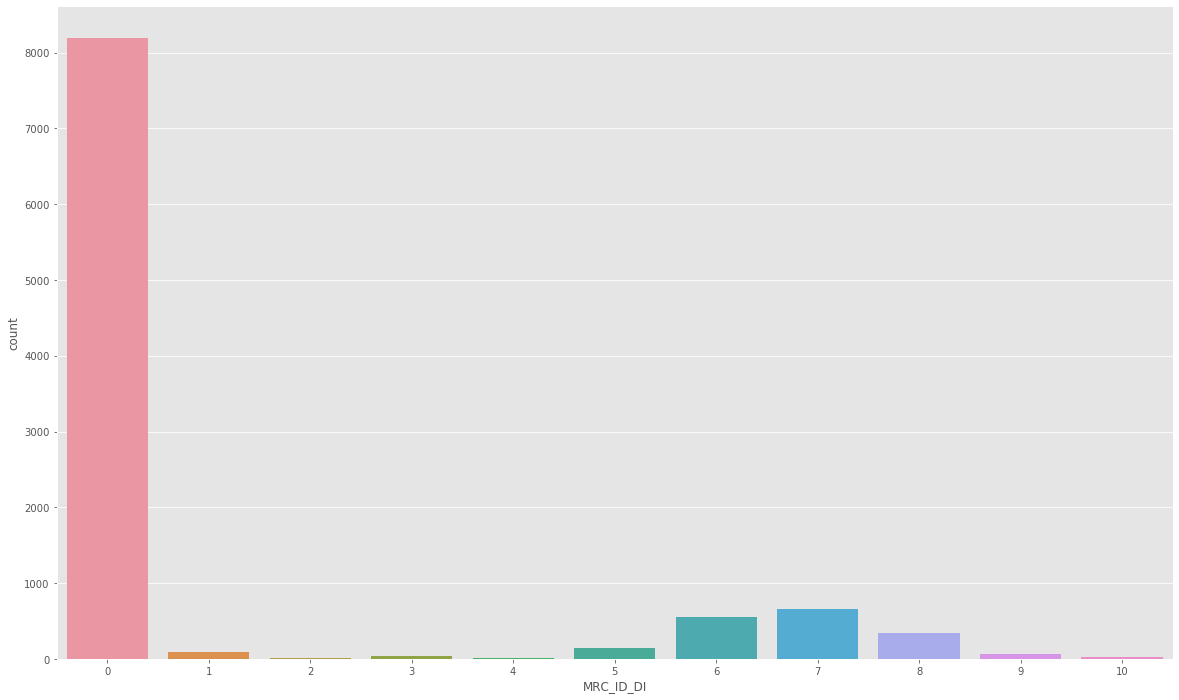

In [36]:
plt.figure(figsize=(20,12))
sns.countplot(train['MRC_ID_DI'])

categorical 데이터 확인

In [37]:
category = []
for i in train.columns:
    if train[i].nunique() < 100 : 
        print(i,train[i].nunique(), train[i].dtype)
        category.append(i)
category=category[:-1]

VAR007 2 int64
VAR015 2 int64
VAR018 2 int64
VAR026 2 int64
VAR059 2 int64
VAR066 2 int64
VAR067 2 int64
VAR070 2 int64
VAR071 2 int64
VAR077 2 int64
VAR078 2 int64
VAR094 2 int64
VAR096 2 int64
VAR097 2 int64
VAR098 2 int64
VAR107 2 int64
VAR111 2 int64
VAR124 2 int64
VAR127 2 int64
VAR143 2 int64
VAR144 2 int64
VAR145 2 int64
VAR148 2 int64
VAR165 2 int64
VAR177 2 int64
VAR179 2 int64
VAR199 2 int64
VAR208 2 int64
MRC_ID_DI 11 int64


train 데이터 셋에서 데이터 타입이 int형인 변수 중 'cst_id_di','MRC_ID_DI' 을 제외한 모든 변수가 카테고리형

In [38]:
category==train.columns[train.dtypes=='int64'][1:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

C:\anaconda\envs\samsung_card\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


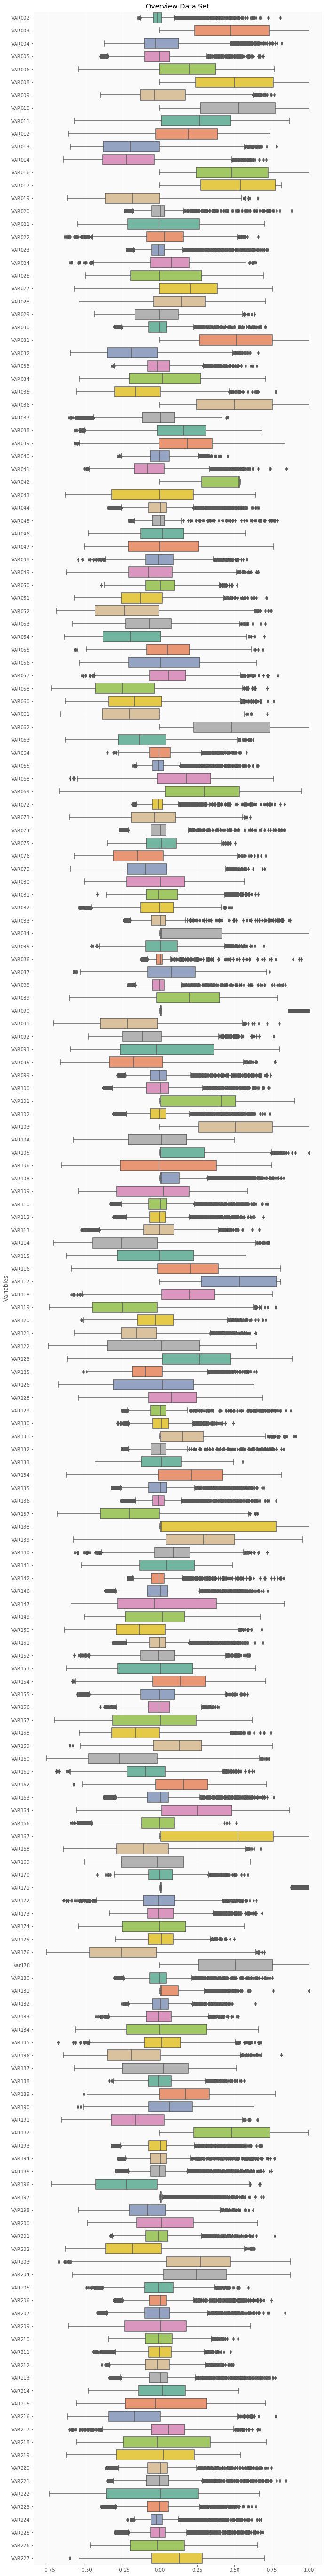

In [39]:
data=train[train.columns[train.dtypes!='int64']]
data['Class']=train['MRC_ID_DI']

plt.style.use('ggplot') # Using ggplot2 style visuals 
f, ax = plt.subplots(figsize = (11, 100)) # 그래프 사이즈

ax.set_facecolor('#fafafa') # 그래프 색상값
# ax.set(xlim = (-5, 5)) # X축 범위
plt.ylabel('Variables') # Y축 이름
plt.title("Overview Data Set") # 그래프 제목
ax = sns.boxplot(data = data.drop(columns = ['Class']), # V1 ~ V28 확인
                 orient = 'h', 
                 palette = 'Set2')

* 수치형 데이터 통계량 확인

In [40]:
train.describe()

,cst_id_di,VAR002,VAR003,VAR004,VAR005,VAR006,VAR007,VAR008,VAR009,VAR010,VAR011,VAR012,VAR013,VAR014,VAR015,VAR016,VAR017,VAR018,VAR019,VAR020,VAR021,VAR022,VAR023,VAR024,VAR025,VAR026,VAR027,VAR028,VAR029,VAR030,VAR031,VAR032,VAR033,VAR034,VAR035,VAR036,VAR037,VAR038,VAR039,VAR040,VAR041,VAR042,VAR043,VAR044,VAR045,VAR046,VAR047,VAR048,VAR049,VAR050,VAR051,VAR052,VAR053,VAR054,VAR055,VAR056,VAR057,VAR058,VAR059,VAR060,VAR061,VAR062,VAR063,VAR064,VAR065,VAR066,VAR067,VAR068,VAR069,VAR070,VAR071,VAR072,VAR073,VAR074,VAR075,VAR076,VAR077,VAR078,VAR079,VAR080,VAR081,VAR082,VAR083,VAR084,VAR085,VAR086,VAR087,VAR088,VAR089,VAR090,VAR091,VAR092,VAR093,VAR094,VAR095,VAR096,VAR097,VAR098,VAR099,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,VAR150,VAR151,VAR152,VAR153,VAR154,VAR155,VAR156,VAR157,VAR158,VAR159,VAR160,VAR161,VAR162,VAR163,VAR164,VAR165,VAR166,VAR167,VAR168,VAR169,VAR170,VAR171,VAR172,VAR173,VAR174,VAR175,VAR176,VAR177,var178,VAR179,VAR180,VAR181,VAR182,VAR183,VAR184,VAR185,VAR186,VAR187,VAR188,VAR189,VAR190,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200,VAR201,VAR202,VAR203,VAR204,VAR205,VAR206,VAR207,VAR208,VAR209,VAR210,VAR211,VAR212,VAR213,VAR214,VAR215,VAR216,VAR217,VAR218,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227,MRC_ID_DI
count,1.012400e+04,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.00000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,10124.000000,

* 학습용 데이터 셋 생성

In [41]:
train2=train.drop(['cst_id_di','MRC_ID_DI'],1)
train2

,VAR002,VAR003,VAR004,VAR005,VAR006,VAR007,VAR008,VAR009,VAR010,VAR011,VAR012,VAR013,VAR014,VAR015,VAR016,VAR017,VAR018,VAR019,VAR020,VAR021,VAR022,VAR023,VAR024,VAR025,VAR026,VAR027,VAR028,VAR029,VAR030,VAR031,VAR032,VAR033,VAR034,VAR035,VAR036,VAR037,VAR038,VAR039,VAR040,VAR041,VAR042,VAR043,VAR044,VAR045,VAR046,VAR047,VAR048,VAR049,VAR050,VAR051,VAR052,VAR053,VAR054,VAR055,VAR056,VAR057,VAR058,VAR059,VAR060,VAR061,VAR062,VAR063,VAR064,VAR065,VAR066,VAR067,VAR068,VAR069,VAR070,VAR071,VAR072,VAR073,VAR074,VAR075,VAR076,VAR077,VAR078,VAR079,VAR080,VAR081,VAR082,VAR083,VAR084,VAR085,VAR086,VAR087,VAR088,VAR089,VAR090,VAR091,VAR092,VAR093,VAR094,VAR095,VAR096,VAR097,VAR098,VAR099,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,VAR150,VAR151,VAR152,VAR153,VAR154,VAR155,VAR156,VAR157,VAR158,VAR159,VAR160,VAR161,VAR162,VAR163,VAR164,VAR165,VAR166,VAR167,VAR168,VAR169,VAR170,VAR171,VAR172,VAR173,VAR174,VAR175,VAR176,VAR177,var178,VAR179,VAR180,VAR181,VAR182,VAR183,VAR184,VAR185,VAR186,VAR187,VAR188,VAR189,VAR190,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200,VAR201,VAR202,VAR203,VAR204,VAR205,VAR206,VAR207,VAR208,VAR209,VAR210,VAR211,VAR212,VAR213,VAR214,VAR215,VAR216,VAR217,VAR218,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227
0,-0.06610,0.5280,-0.13607,0.10945,0.06557,0,0.7702,-0.18965,0.1981,0.24149,0.32429,-0.18611,0.06960,1,0.0049,0.8085,0,-0.11899,0.03969,-0.16651,0.12037,-0.01715,-0.09941,-0.28878,0,-0.07481,-0.12742,0.14367,0.06725,0.7702,0.04138,-0.01619,-0.32429,0.11580,0.7179,0.16920,-0.08048,0.28126,-0.11289,-0.02092,0.5381,0.22047,0.17756,0.03794,-0.04432,-0.28743,-0.01164,0.26300,-0.15466,-0.08374,-0.12935,-0.24726,-0.32134,0.39311,-0.32813,0.35632,0.12739,1,-0.18338,-0.07717,0.4688,0.18707,-0.03818,-0.04869,1,1,-0.14361,0.20281,0,0,0.02536,-0.20705,0.03747,0.28517,-0.18100,0,0,-0.20069,0.23156,-0.18709,0.20059,0.04329,0.0025,0.13105,-0.00891,0.23236,0.10216,0.28202,0.0077,-0.09886,0.29902,-0.22713,0,-0.23064,0,0,0,0.06628,0.11613,0.0093,0.03583,0.3578,0.20585,1.0000,-0.29631,0,0.0008,0.26873,0.05674,0,0.02082,0.26616,-0.25601,0.16075,0.15089,0.7286,0.07524,-0.11761,-0.13649,0.16103,0.38476,0.18881,0,0.00524,0.29896,1,0.36885,0.05585,0.06960,0.0068,0.05439,-0.04895,0.22997,0.06607,-0.02500,-0.05500,0.0020,0.07158,-0.11915,-0.09522,0.11580,1,0,0,0.35606,-0.32429,0,0.19451,-0.22885,0.01926,-0.15068,0.13834,-0.16525,0.09025,0.01253,0.20219,0.31263,-0.17855,-0.20515,-0.18453,-0.21851,0.37549,-0.10744,0,0.13043,0.0013,-0.17485,0.18986,-0.07305,0.0069,-0.30157,-0.16382,0.28385,-0.14273,-0.27069,0,0.3766,0,0.06165,0.0021,-0.03891,0.04840,-0.14790,0.26533,-0.00426,0.14765,-0.13332,0.03077,0.23017,0.11764,0.5740,0.06403,0.06184,0.04242,-0.04322,0.0051,0.04523,0,0.07247,0.09631,-0.22864,0.07262,-0.08837,0.01070,0.06340,0.12424,0,0.20392,0.24685,0.01432,-0.00966,0.09746,-0.17616,-0.18956,-0.13676,-0.13279,-0.32829,0.19113,0.05449,0.09471,0.27091,0.01931,0.02938,0.17105,0.12537,0.22197
1,-0.09537,0.1347,-0.13541,0.17331,-0.19657,0,0.0616,-0.23104,0.4940,-0.39476,-0.38366,0.39329,0.17549,0,0.3130,0.6564,0,0.31544,0.03794,-0.30237,-0.34538,0.04368,0.04381,-0.19160,0,-0.09801,-0.04593,0.11228,0.11692,0.5661,0.19938,0.01259,-0.17976,0.20081,0.7454,0.24256,0.01363,-0.22807,0.06728,0.17312,0.5369,0.23387,0.04572,0.05406,-0.18782,-0.23752,-0.10148,-0.16942,0.02893,0.03702,0.04855,0.36531,0.24302,-0.30677,-0.20810,-0.12376,0.15054,0,0.22430,0.10513,0.3797,-0.16796,0.01456,-0.10743,0,1,-0.08246,-0.38202,0,0,0.02066,0.28113,0.05687,-0.11689,0.16837,1,1,-0.08043,0.21618,-0.20256,0.23597,0.06233,0.3285,0.05898,0.00544,-0.29231,0.02483,-0.38122,0.0065,0.39975,0.09775,-0.34015,0,0.24286,0,0,0,0.10304,0.73571,0

## feature engineering

* 목표변수 상관계수의 절댓값이 0.3 이상인 값 선정 > 42개(corr_import)

In [42]:
corr_import_pos=train.corr()['MRC_ID_DI'][(train.corr()['MRC_ID_DI']>0.3)].index
corr_import_pos=corr_import_pos.drop(['MRC_ID_DI'])
print('상관계수 기준 중요 변수',corr_import_pos, sep='\n')
print('상관계수 기준 중요 변수 갯수 :',len(corr_import_pos))

상관계수 기준 중요 변수
Index(['VAR013', 'VAR029', 'VAR035', 'VAR043', 'VAR051', 'VAR076', 'VAR080',
       'VAR095', 'VAR104', 'VAR115', 'VAR122', 'VAR126', 'VAR150', 'VAR153',
       'VAR157', 'VAR187', 'VAR202', 'VAR219', 'VAR222', 'VAR226'],
      dtype='object')
상관계수 기준 중요 변수 갯수 : 20


In [43]:
corr_import_neg=train.corr()['MRC_ID_DI'][(train.corr()['MRC_ID_DI']<-0.3)].index
print('상관계수 기준 중요 변수',corr_import_neg, sep='\n')
print('상관계수 기준 중요 변수 갯수 :',len(corr_import_neg))

상관계수 기준 중요 변수
Index(['VAR006', 'VAR012', 'VAR021', 'VAR034', 'VAR046', 'VAR047', 'VAR056',
       'VAR069', 'VAR075', 'VAR089', 'VAR093', 'VAR106', 'VAR116', 'VAR123',
       'VAR133', 'VAR134', 'VAR147', 'VAR184', 'VAR214', 'VAR215', 'VAR218',
       'VAR227'],
      dtype='object')
상관계수 기준 중요 변수 갯수 : 22


* 중요 변수 카테고리형 여부 파악

In [44]:
for i in range(len(corr_import_neg)):
    print(train.loc[:,corr_import_neg].columns[train.loc[:,corr_import_neg].dtypes=='int64'])

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [45]:
for i in range(len(corr_import_pos)):
    print(train.loc[:,corr_import_pos].columns[train.loc[:,corr_import_pos].dtypes=='int64'])

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


* 카테고리형 변수가 없기 때문에 중요 변수 통계량 추가

## feature engineering

* 합 : 감소, 평균 : 감소 > 과적합?

In [46]:
# train2=train2.drop(['cbc_top_fi'],axis=1)

In [47]:
corr_top_sum=train2.loc[:,corr_import_pos].sum(axis=1)-train2.loc[:,corr_import_neg].sum(axis=1)
train2['corr_top_sum']=corr_top_sum

In [48]:
# corr_top_mean=train2.loc[:,corr_import_pos].mean(axis=1)-train2.loc[:,corr_import_neg].mean(axis=1)

# train2['corr_top_mean']=corr_top_mean
# train2

# [try] 밑의 과정을 카테고리형-수치형으로 묶어서 그룹화 해보기

#### [보류]1) 목표변수 상관계수의 절댓값 상위 5개 변수 선정(fe_top5)

In [49]:
fe_top5=abs(train.corr()['MRC_ID_DI']).sort_values(ascending=False)[1:6].index
fe_top5

Index(['VAR226', 'VAR115', 'VAR021', 'VAR104', 'VAR046'], dtype='object')

* 뽑은 변수 중 카테고리형 변수 확인 > 없음

In [50]:
train.loc[:,list(np.sort(fe_top5))].columns[train.loc[:,list(np.sort(fe_top5))].dtypes=='int64']

Index([], dtype='object')

#### [보류] 2) 상관계수 기준 중요변수별 상관계수 절댓값 0.9 이상 찾기(top5_up09)

In [51]:
top5_up09=[]
for i in list(fe_top5) :
    sort_corr=abs(train2.corr()[i]).sort_values(ascending=False)
    top5_up09.append(list(sort_corr[sort_corr>0.9].index[1:]))
print('top5_up09.shape :',np.array(top5_up09).shape)

top5_up09.shape : (5,)


* 뽑은 변수 중 카테고리형 변수 여부 확인 > 없음

In [52]:
for i in range(len(top5_up09)):
    print(train.loc[:,top5_up09[i]].columns[train.loc[:,top5_up09[i]].dtypes=='int64'])

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


C:\anaconda\envs\samsung_card\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [53]:
top5_up09[0]

['VAR115', 'VAR021', 'VAR153', 'VAR056', 'VAR047', 'corr_top_sum']

* top5 변수와 각 변수의 상관관계가 0.9 이상인 값 관계

In [54]:
for i in range(len(fe_top5)):
    print(fe_top5[i], '-', top5_up09[i], end='\n\n')

VAR226 - ['VAR115', 'VAR021', 'VAR153', 'VAR056', 'VAR047', 'corr_top_sum']

VAR115 - ['VAR153', 'VAR021', 'VAR157', 'VAR056', 'VAR219', 'VAR122', 'corr_top_sum', 'VAR047', 'VAR222', 'VAR106', 'VAR147', 'VAR034', 'VAR218', 'VAR226', 'VAR104', 'VAR080', 'VAR126', 'VAR093', 'VAR043', 'VAR187', 'VAR184']

VAR021 - ['VAR115', 'VAR153', 'VAR219', 'VAR157', 'corr_top_sum', 'VAR104', 'VAR056', 'VAR122', 'VAR047', 'VAR226', 'VAR106', 'VAR222', 'VAR147', 'VAR080', 'VAR126', 'VAR187', 'VAR218', 'VAR034', 'VAR093']

VAR104 - ['VAR021', 'VAR047', 'VAR115', 'VAR056', 'VAR153', 'VAR157', 'VAR122', 'VAR219']

VAR046 - ['VAR214']



# + 다항차수 변환을 이용한 교호작용 변수 생성 고려 필요
# + 사이킷런의 VarianceThreshold을 통해 분산이 0(혹은 매우 낮은 값)인 데이터를 제거하는 변수 선택 고려 필요

# 모델링
  - kfold, 단일 모델 앙상블 추가
  - 학습 데이터가 적고 class imbalance 문제가 크기 때문에 최대한 과적합을 피하는 방향으로 설계함

## 1. 트리모델

### 자체 평가셋 생성
  - x_train, y_train : 학습 데이터, 학습 class
  - x_valid, y_valid : 평가 데이터, 평가(정답) class

In [55]:
x_train, x_valid, y_train, y_valid = train_test_split(train2, label['MRC_ID_DI'],stratify=label['MRC_ID_DI'],random_state=42, test_size=0.3)

### catboost

1) basline : 0.7888719839, 0.8686563930972191<br>
2) 카테고리 지정 : 0.8179702443, 0.8716032085356743<br>
3) earlystopping=80 : 0.8268276801, 0.8740443843662227<br>
4) 
>가. corr_top_sum 추가 : 0.8122366584, 0.8716338180340142<br>
나. corr_top_mean 추가 : 0.7902519043, 0.8582008216666602

In [56]:
cbc=CatBoostClassifier(learning_rate=0.1,eval_metric='AUC',random_state=42)
cbc.fit(x_train.iloc[:,:-1],y_train, eval_set=[(x_train.iloc[:,:-1],y_train),(x_valid.iloc[:,:-1],y_valid)],early_stopping_rounds=80,cat_features=category)
cbc_result=cbc.predict_proba(x_valid.iloc[:,:-1])
catboost_ovr=roc_auc_score(y_valid, cbc_result,multi_class="ovr")
print('catboost_auroc_ovr', catboost_ovr)

0:	test: 0.6075615	test1: 0.5164843	best: 0.5164843 (0)	total: 330ms	remaining: 5m 29s
1:	test: 0.6850031	test1: 0.5948407	best: 0.5948407 (1)	total: 548ms	remaining: 4m 33s
2:	test: 0.7138183	test1: 0.6279684	best: 0.6279684 (2)	total: 745ms	remaining: 4m 7s
3:	test: 0.7406125	test1: 0.6203986	best: 0.6279684 (2)	total: 937ms	remaining: 3m 53s
4:	test: 0.7579508	test1: 0.6296452	best: 0.6296452 (4)	total: 1.15s	remaining: 3m 49s
5:	test: 0.7794520	test1: 0.6260094	best: 0.6296452 (4)	total: 1.37s	remaining: 3m 46s
6:	test: 0.7878317	test1: 0.6367912	best: 0.6367912 (6)	total: 1.58s	remaining: 3m 44s
7:	test: 0.7921980	test1: 0.6532350	best: 0.6532350 (7)	total: 1.79s	remaining: 3m 42s
8:	test: 0.7993524	test1: 0.6526904	best: 0.6532350 (7)	total: 2.01s	remaining: 3m 40s
9:	test: 0.8000339	test1: 0.6462817	best: 0.6532350 (7)	total: 2.22s	remaining: 3m 39s
10:	test: 0.8018481	test1: 0.6340500	best: 0.6532350 (7)	total: 2.43s	remaining: 3m 38s
11:	test: 0.8083982	test1: 0.6478015	best: 

93:	test: 0.9864585	test1: 0.7611660	best: 0.7641304 (64)	total: 19.7s	remaining: 3m 9s
94:	test: 0.9865516	test1: 0.7613665	best: 0.7641304 (64)	total: 19.9s	remaining: 3m 9s
95:	test: 0.9867389	test1: 0.7605780	best: 0.7641304 (64)	total: 20.1s	remaining: 3m 9s
96:	test: 0.9870051	test1: 0.7653116	best: 0.7653116 (96)	total: 20.3s	remaining: 3m 8s
97:	test: 0.9872300	test1: 0.7679321	best: 0.7679321 (97)	total: 20.5s	remaining: 3m 8s
98:	test: 0.9873653	test1: 0.7681135	best: 0.7681135 (98)	total: 20.7s	remaining: 3m 8s
99:	test: 0.9876051	test1: 0.7675664	best: 0.7681135 (98)	total: 20.9s	remaining: 3m 8s
100:	test: 0.9876841	test1: 0.7691557	best: 0.7691557 (100)	total: 21.1s	remaining: 3m 7s
101:	test: 0.9879204	test1: 0.7683942	best: 0.7691557 (100)	total: 21.3s	remaining: 3m 7s
102:	test: 0.9880838	test1: 0.7719990	best: 0.7719990 (102)	total: 21.5s	remaining: 3m 7s
103:	test: 0.9881355	test1: 0.7733268	best: 0.7733268 (103)	total: 21.7s	remaining: 3m 7s
104:	test: 0.9882845	tes

184:	test: 0.9952583	test1: 0.7989886	best: 0.8021270 (154)	total: 38.5s	remaining: 2m 49s
185:	test: 0.9953066	test1: 0.7989558	best: 0.8021270 (154)	total: 38.7s	remaining: 2m 49s
186:	test: 0.9953471	test1: 0.7992598	best: 0.8021270 (154)	total: 38.9s	remaining: 2m 49s
187:	test: 0.9953948	test1: 0.8004945	best: 0.8021270 (154)	total: 39.1s	remaining: 2m 49s
188:	test: 0.9954521	test1: 0.7997925	best: 0.8021270 (154)	total: 39.3s	remaining: 2m 48s
189:	test: 0.9954726	test1: 0.7991067	best: 0.8021270 (154)	total: 39.5s	remaining: 2m 48s
190:	test: 0.9955017	test1: 0.7995386	best: 0.8021270 (154)	total: 39.8s	remaining: 2m 48s
191:	test: 0.9955301	test1: 0.7981059	best: 0.8021270 (154)	total: 40s	remaining: 2m 48s
192:	test: 0.9955509	test1: 0.7982240	best: 0.8021270 (154)	total: 40.2s	remaining: 2m 47s
193:	test: 0.9955959	test1: 0.7988239	best: 0.8021270 (154)	total: 40.4s	remaining: 2m 47s
194:	test: 0.9956537	test1: 0.8002004	best: 0.8021270 (154)	total: 40.6s	remaining: 2m 47s
1

276:	test: 0.9978440	test1: 0.8054175	best: 0.8079096 (245)	total: 57.7s	remaining: 2m 30s
277:	test: 0.9978515	test1: 0.8061672	best: 0.8079096 (245)	total: 57.9s	remaining: 2m 30s
278:	test: 0.9978717	test1: 0.8062115	best: 0.8079096 (245)	total: 58.1s	remaining: 2m 30s
279:	test: 0.9978873	test1: 0.8071332	best: 0.8079096 (245)	total: 58.3s	remaining: 2m 30s
280:	test: 0.9979002	test1: 0.8084759	best: 0.8084759 (280)	total: 58.5s	remaining: 2m 29s
281:	test: 0.9979112	test1: 0.8081507	best: 0.8084759 (280)	total: 58.7s	remaining: 2m 29s
282:	test: 0.9979160	test1: 0.8087736	best: 0.8087736 (282)	total: 59s	remaining: 2m 29s
283:	test: 0.9979300	test1: 0.8096992	best: 0.8096992 (283)	total: 59.2s	remaining: 2m 29s
284:	test: 0.9979432	test1: 0.8111874	best: 0.8111874 (284)	total: 59.4s	remaining: 2m 28s
285:	test: 0.9979484	test1: 0.8096076	best: 0.8111874 (284)	total: 59.6s	remaining: 2m 28s
286:	test: 0.9979577	test1: 0.8135949	best: 0.8135949 (286)	total: 59.8s	remaining: 2m 28s
2

366:	test: 0.9988780	test1: 0.8176170	best: 0.8183159 (365)	total: 1m 16s	remaining: 2m 11s
367:	test: 0.9988817	test1: 0.8175570	best: 0.8183159 (365)	total: 1m 16s	remaining: 2m 11s
368:	test: 0.9988920	test1: 0.8164355	best: 0.8183159 (365)	total: 1m 16s	remaining: 2m 11s
369:	test: 0.9988961	test1: 0.8172061	best: 0.8183159 (365)	total: 1m 17s	remaining: 2m 11s
370:	test: 0.9988949	test1: 0.8181109	best: 0.8183159 (365)	total: 1m 17s	remaining: 2m 11s
371:	test: 0.9989097	test1: 0.8174751	best: 0.8183159 (365)	total: 1m 17s	remaining: 2m 10s
372:	test: 0.9989117	test1: 0.8179064	best: 0.8183159 (365)	total: 1m 17s	remaining: 2m 10s
373:	test: 0.9989199	test1: 0.8176525	best: 0.8183159 (365)	total: 1m 17s	remaining: 2m 10s
374:	test: 0.9989279	test1: 0.8173363	best: 0.8183159 (365)	total: 1m 18s	remaining: 2m 10s
375:	test: 0.9989498	test1: 0.8175283	best: 0.8183159 (365)	total: 1m 18s	remaining: 2m 9s
376:	test: 0.9989571	test1: 0.8179546	best: 0.8183159 (365)	total: 1m 18s	remaini

456:	test: 0.9994304	test1: 0.8210807	best: 0.8258965 (438)	total: 1m 35s	remaining: 1m 52s
457:	test: 0.9994377	test1: 0.8209089	best: 0.8258965 (438)	total: 1m 35s	remaining: 1m 52s
458:	test: 0.9994397	test1: 0.8212901	best: 0.8258965 (438)	total: 1m 35s	remaining: 1m 52s
459:	test: 0.9994482	test1: 0.8216737	best: 0.8258965 (438)	total: 1m 35s	remaining: 1m 52s
460:	test: 0.9994498	test1: 0.8216737	best: 0.8258965 (438)	total: 1m 35s	remaining: 1m 52s
461:	test: 0.9994554	test1: 0.8214435	best: 0.8258965 (438)	total: 1m 36s	remaining: 1m 51s
462:	test: 0.9994600	test1: 0.8211391	best: 0.8258965 (438)	total: 1m 36s	remaining: 1m 51s
463:	test: 0.9994646	test1: 0.8220775	best: 0.8258965 (438)	total: 1m 36s	remaining: 1m 51s
464:	test: 0.9994675	test1: 0.8203480	best: 0.8258965 (438)	total: 1m 36s	remaining: 1m 51s
465:	test: 0.9994708	test1: 0.8204849	best: 0.8258965 (438)	total: 1m 36s	remaining: 1m 51s
466:	test: 0.9994777	test1: 0.8207079	best: 0.8258965 (438)	total: 1m 37s	remain

546:	test: 0.9996659	test1: 0.8250397	best: 0.8268277 (521)	total: 1m 53s	remaining: 1m 34s
547:	test: 0.9996708	test1: 0.8266294	best: 0.8268277 (521)	total: 1m 53s	remaining: 1m 33s
548:	test: 0.9996781	test1: 0.8265433	best: 0.8268277 (521)	total: 1m 54s	remaining: 1m 33s
549:	test: 0.9996796	test1: 0.8245977	best: 0.8268277 (521)	total: 1m 54s	remaining: 1m 33s
550:	test: 0.9996817	test1: 0.8242526	best: 0.8268277 (521)	total: 1m 54s	remaining: 1m 33s
551:	test: 0.9996836	test1: 0.8262252	best: 0.8268277 (521)	total: 1m 54s	remaining: 1m 33s
552:	test: 0.9996864	test1: 0.8241924	best: 0.8268277 (521)	total: 1m 54s	remaining: 1m 32s
553:	test: 0.9996906	test1: 0.8243160	best: 0.8268277 (521)	total: 1m 55s	remaining: 1m 32s
554:	test: 0.9996922	test1: 0.8257987	best: 0.8268277 (521)	total: 1m 55s	remaining: 1m 32s
555:	test: 0.9996978	test1: 0.8239848	best: 0.8268277 (521)	total: 1m 55s	remaining: 1m 32s
556:	test: 0.9996989	test1: 0.8237835	best: 0.8268277 (521)	total: 1m 55s	remain

### random_forest

* 튜닝 : 0.8607747039084298
> corr_import_sum : 0.8656010369017776

In [57]:
x_train

,VAR002,VAR003,VAR004,VAR005,VAR006,VAR007,VAR008,VAR009,VAR010,VAR011,VAR012,VAR013,VAR014,VAR015,VAR016,VAR017,VAR018,VAR019,VAR020,VAR021,VAR022,VAR023,VAR024,VAR025,VAR026,VAR027,VAR028,VAR029,VAR030,VAR031,VAR032,VAR033,VAR034,VAR035,VAR036,VAR037,VAR038,VAR039,VAR040,VAR041,VAR042,VAR043,VAR044,VAR045,VAR046,VAR047,VAR048,VAR049,VAR050,VAR051,VAR052,VAR053,VAR054,VAR055,VAR056,VAR057,VAR058,VAR059,VAR060,VAR061,VAR062,VAR063,VAR064,VAR065,VAR066,VAR067,VAR068,VAR069,VAR070,VAR071,VAR072,VAR073,VAR074,VAR075,VAR076,VAR077,VAR078,VAR079,VAR080,VAR081,VAR082,VAR083,VAR084,VAR085,VAR086,VAR087,VAR088,VAR089,VAR090,VAR091,VAR092,VAR093,VAR094,VAR095,VAR096,VAR097,VAR098,VAR099,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,VAR150,VAR151,VAR152,VAR153,VAR154,VAR155,VAR156,VAR157,VAR158,VAR159,VAR160,VAR161,VAR162,VAR163,VAR164,VAR165,VAR166,VAR167,VAR168,VAR169,VAR170,VAR171,VAR172,VAR173,VAR174,VAR175,VAR176,VAR177,var178,VAR179,VAR180,VAR181,VAR182,VAR183,VAR184,VAR185,VAR186,VAR187,VAR188,VAR189,VAR190,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200,VAR201,VAR202,VAR203,VAR204,VAR205,VAR206,VAR207,VAR208,VAR209,VAR210,VAR211,VAR212,VAR213,VAR214,VAR215,VAR216,VAR217,VAR218,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227,corr_top_sum
8189,0.25744,0.3184,-0.04218,0.06117,0.16146,0,0.9584,-0.11174,0.9564,0.20081,0.20735,-0.06488,-0.23394,1,0.5821,0.8140,0,-0.07065,0.06677,-0.09480,0.07205,-0.00760,0.13548,-0.11764,0,0.17083,0.04489,0.02830,0.05700,0.6504,-0.00370,-0.04596,-0.09199,-0.18609,0.8625,0.03341,0.13526,0.17036,-0.03070,-0.06581,0.5378,0.09636,0.04047,0.02870,0.17267,-0.12592,-0.00741,0.09056,0.10775,-0.07604,-0.23637,-0.10550,-0.14077,0.14799,-0.13685,-0.02306,-0.28261,0,-0.22234,-0.21092,0.7142,-0.19452,0.23199,0.13727,1,1,0.19828,0.19888,0,0,0.11858,-0.12781,0.03181,0.00584,-0.15832,1,0,-0.06367,0.33178,-0.09461,0.11951,0.02633,0.2204,0.00265,0.02277,0.13786,0.08395,0.25917,0.0024,-0.22707,-0.11376,0.02077,0,-0.12006,0,0,0,0.01892,0.02772,0.5119,0.00255,0.1193,0.06632,0.0099,-0.00111,0,0.0003,0.18324,0.03896,1,0.00765,-0.04127,-0.25990,0.10978,0.13548,0.6499,0.17337,-0.16461,-0.12598,-0.23796,0.22396,0.25111,1,-0.22150,0.04376,0,0.08429,0.01947,-0.01805,0.2311,0.01867,0.07592,0.14120,0.01499,0.00847,-0.15859,0.0083,0.21315,0.12990,0.07461,0.09448,0,0,0,0.00680,-0.19852,0,0.14109,-0.04919,0.01628,0.17746,0.14665,0.04396,0.08532,0.21236,0.04213,-0.15082,0.11053,-0.24522,0.00790,0.11210,-0.01174,0.22281,1,0.12670,0.7849,-0.21918,0.08021,-0.18558,0.0098,0.00568,-0.09787,0.09259,0.23211,-0.21049,0,0.3342,0,0.04094,0.1233,0.05211,-0.01105,-0.00163,0.01984,-0.16379,0.06447,-0.01645,0.00487,-0.01882,-0.06345,0.6861,0.01204,0.01524,0.02784,-0.14567,0.0045,0.00499,0,-0.06886,0.10944,-0.06126,0.25344,0.22477,-0.04627,0.01667,0.06447,0,-0.02724,0.24720,-0.04702,0.12611,0.00204,-0.03175,-0.04956,-0.08471,0.07100,-0.18045,0.14954,0.04504,0.04355,0.10866,0.09267,0.26427,0.01125,0.16048,0.07803,0.06105
1591,-0.03972,0.0366,-0.07803,0.21794,-0.06248,0,0.6351,-0.19116,0.9655,-0.04212,-0.08199,0.08406,-0.05012,0,0.2652,0.7553,0,0.27777,0.05029,-0.36245,-0.17222,-0.07757,0.12700,-0.24559,0,-0.05651,-0.05924,0.30527,0.16828,0.6483,0.07801,-0.13898,-0.32212,0.20241,0.8344,0.23935,-0.11706,-0.18653,0.03145,-0.00480,0.5391,0.37856,0.06101,0.04651,-0.15611,-0.32896,0.08049,-0.03205,0.06497,0.18327,0.02961,0.04869,0.00152,-0.04977,-0.35923,-0.00179,0.03249,0,0.00317,0.16592,0.0676,0.13885,0.09466,-0.10668,0,1,-0.00118,-0.17800,0,0,0.04902,0.18643,0.05156,-0.09755,0.05247,0,0,0.03723,0.25096,-0.23458,0.30944,0.06489,0.0081,-0.06539,0.00327,-0.10765,0.04033,-0.21235,0.8935,0.04064,-0.07273,-0.49772,0,0.05652,

In [58]:
rf=RandomForestClassifier(random_state=42,n_jobs=-1,max_depth=6,n_estimators=1000)
rf.fit(x_train,y_train)
rf_result=rf.predict_proba(x_valid)
rf_ovr=roc_auc_score(y_valid, rf_result,multi_class="ovr")
print('randomforest_auroc_ovr', rf_ovr)

randomforest_auroc_ovr 0.8656010369017776


### xgboost

1) baseline : 0.8484725688953675<br>
2) n_estimators=500,learning_rate=0.05,max_depth=5 : 0.8657359561473086<br>
3) corr_import_sum : 0.8670763622619604

In [59]:
xgb=XGBClassifier(njobs=-1,random_state=42,n_estimators=500,learning_rate=0.05,max_depth=5)
xgb.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_valid,y_valid)], eval_metric='mlogloss')
xgb_result=xgb.predict_proba(x_valid)
xgboost_ovr=roc_auc_score(y_valid, xgb_result,multi_class="ovr")
print('xgboost_auroc', xgboost_ovr)

[0]	validation_0-mlogloss:2.20688	validation_1-mlogloss:2.21251
[1]	validation_0-mlogloss:2.05609	validation_1-mlogloss:2.06754
[2]	validation_0-mlogloss:1.93008	validation_1-mlogloss:1.94755
[3]	validation_0-mlogloss:1.82193	validation_1-mlogloss:1.84539
[4]	validation_0-mlogloss:1.72718	validation_1-mlogloss:1.75647
[5]	validation_0-mlogloss:1.64350	validation_1-mlogloss:1.67837
[6]	validation_0-mlogloss:1.56795	validation_1-mlogloss:1.60810
[7]	validation_0-mlogloss:1.49976	validation_1-mlogloss:1.54482
[8]	validation_0-mlogloss:1.43762	validation_1-mlogloss:1.48714
[9]	validation_0-mlogloss:1.38037	validation_1-mlogloss:1.43465
[10]	validation_0-mlogloss:1.32770	validation_1-mlogloss:1.38681
[11]	validation_0-mlogloss:1.27872	validation_1-mlogloss:1.34247
[12]	validation_0-mlogloss:1.23334	validation_1-mlogloss:1.30178
[13]	validation_0-mlogloss:1.19070	validation_1-mlogloss:1.26384
[14]	validation_0-mlogloss:1.15089	validation_1-mlogloss:1.22851
[15]	validation_0-mlogloss:1.11376	

[126]	validation_0-mlogloss:0.27014	validation_1-mlogloss:0.63255
[127]	validation_0-mlogloss:0.26852	validation_1-mlogloss:0.63253
[128]	validation_0-mlogloss:0.26716	validation_1-mlogloss:0.63237
[129]	validation_0-mlogloss:0.26568	validation_1-mlogloss:0.63244
[130]	validation_0-mlogloss:0.26428	validation_1-mlogloss:0.63241
[131]	validation_0-mlogloss:0.26293	validation_1-mlogloss:0.63248
[132]	validation_0-mlogloss:0.26143	validation_1-mlogloss:0.63248
[133]	validation_0-mlogloss:0.26009	validation_1-mlogloss:0.63242
[134]	validation_0-mlogloss:0.25880	validation_1-mlogloss:0.63243
[135]	validation_0-mlogloss:0.25748	validation_1-mlogloss:0.63259
[136]	validation_0-mlogloss:0.25571	validation_1-mlogloss:0.63262
[137]	validation_0-mlogloss:0.25423	validation_1-mlogloss:0.63275
[138]	validation_0-mlogloss:0.25288	validation_1-mlogloss:0.63276
[139]	validation_0-mlogloss:0.25188	validation_1-mlogloss:0.63288
[140]	validation_0-mlogloss:0.25075	validation_1-mlogloss:0.63285
[141]	vali

[251]	validation_0-mlogloss:0.14904	validation_1-mlogloss:0.65640
[252]	validation_0-mlogloss:0.14849	validation_1-mlogloss:0.65681
[253]	validation_0-mlogloss:0.14774	validation_1-mlogloss:0.65700
[254]	validation_0-mlogloss:0.14706	validation_1-mlogloss:0.65731
[255]	validation_0-mlogloss:0.14638	validation_1-mlogloss:0.65758
[256]	validation_0-mlogloss:0.14565	validation_1-mlogloss:0.65786
[257]	validation_0-mlogloss:0.14523	validation_1-mlogloss:0.65818
[258]	validation_0-mlogloss:0.14472	validation_1-mlogloss:0.65836
[259]	validation_0-mlogloss:0.14404	validation_1-mlogloss:0.65874
[260]	validation_0-mlogloss:0.14356	validation_1-mlogloss:0.65896
[261]	validation_0-mlogloss:0.14298	validation_1-mlogloss:0.65916
[262]	validation_0-mlogloss:0.14220	validation_1-mlogloss:0.65939
[263]	validation_0-mlogloss:0.14156	validation_1-mlogloss:0.65962
[264]	validation_0-mlogloss:0.14062	validation_1-mlogloss:0.66002
[265]	validation_0-mlogloss:0.14003	validation_1-mlogloss:0.66031
[266]	vali

[376]	validation_0-mlogloss:0.08572	validation_1-mlogloss:0.69005
[377]	validation_0-mlogloss:0.08529	validation_1-mlogloss:0.69035
[378]	validation_0-mlogloss:0.08488	validation_1-mlogloss:0.69045
[379]	validation_0-mlogloss:0.08450	validation_1-mlogloss:0.69064
[380]	validation_0-mlogloss:0.08416	validation_1-mlogloss:0.69099
[381]	validation_0-mlogloss:0.08388	validation_1-mlogloss:0.69115
[382]	validation_0-mlogloss:0.08357	validation_1-mlogloss:0.69134
[383]	validation_0-mlogloss:0.08319	validation_1-mlogloss:0.69159
[384]	validation_0-mlogloss:0.08293	validation_1-mlogloss:0.69164
[385]	validation_0-mlogloss:0.08265	validation_1-mlogloss:0.69195
[386]	validation_0-mlogloss:0.08227	validation_1-mlogloss:0.69227
[387]	validation_0-mlogloss:0.08195	validation_1-mlogloss:0.69246
[388]	validation_0-mlogloss:0.08153	validation_1-mlogloss:0.69269
[389]	validation_0-mlogloss:0.08117	validation_1-mlogloss:0.69286
[390]	validation_0-mlogloss:0.08081	validation_1-mlogloss:0.69307
[391]	vali

### LGBM

1) baseline : 0.8327298769737652
> 카테고리형 추가 : 변화 없음<br>

2) lr=0.05, n_estimators=500 : 0.853103891901965
> num_leaves=63 : 큰 변화 없음

3) corr_top_sum = 0.857740242126912

In [60]:
lgbm=LGBMClassifier(njobs=-1,random_state=42,n_estimators=500,learning_rate=0.05,num_leaves=31)
lgbm.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_valid,y_valid)],eval_metric='logloss')
lgbm_result=lgbm.predict_proba(x_valid)
lightgbm_ovr=roc_auc_score(y_valid, lgbm_result,multi_class="ovr")
print('lightgbm_auroc', lightgbm_ovr)

[1]	training's multi_logloss: 0.753507	valid_1's multi_logloss: 0.78774
[2]	training's multi_logloss: 0.715342	valid_1's multi_logloss: 0.774757
[3]	training's multi_logloss: 0.684832	valid_1's multi_logloss: 0.765463
[4]	training's multi_logloss: 0.657931	valid_1's multi_logloss: 0.756669
[5]	training's multi_logloss: 0.634431	valid_1's multi_logloss: 0.74869
[6]	training's multi_logloss: 0.613313	valid_1's multi_logloss: 0.741994
[7]	training's multi_logloss: 0.594146	valid_1's multi_logloss: 0.734936
[8]	training's multi_logloss: 0.576809	valid_1's multi_logloss: 0.728636
[9]	training's multi_logloss: 0.560704	valid_1's multi_logloss: 0.723805
[10]	training's multi_logloss: 0.545665	valid_1's multi_logloss: 0.718829
[11]	training's multi_logloss: 0.531342	valid_1's multi_logloss: 0.714279
[12]	training's multi_logloss: 0.517944	valid_1's multi_logloss: 0.709939
[13]	training's multi_logloss: 0.505392	valid_1's multi_logloss: 0.706104
[14]	training's multi_logloss: 0.493585	valid_1's

[113]	training's multi_logloss: 0.126564	valid_1's multi_logloss: 0.684806
[114]	training's multi_logloss: 0.125275	valid_1's multi_logloss: 0.68574
[115]	training's multi_logloss: 0.124085	valid_1's multi_logloss: 0.68646
[116]	training's multi_logloss: 0.122841	valid_1's multi_logloss: 0.687232
[117]	training's multi_logloss: 0.121627	valid_1's multi_logloss: 0.688174
[118]	training's multi_logloss: 0.120384	valid_1's multi_logloss: 0.689002
[119]	training's multi_logloss: 0.11926	valid_1's multi_logloss: 0.689673
[120]	training's multi_logloss: 0.118063	valid_1's multi_logloss: 0.690518
[121]	training's multi_logloss: 0.116835	valid_1's multi_logloss: 0.69149
[122]	training's multi_logloss: 0.115672	valid_1's multi_logloss: 0.692067
[123]	training's multi_logloss: 0.114549	valid_1's multi_logloss: 0.692783
[124]	training's multi_logloss: 0.113411	valid_1's multi_logloss: 0.693595
[125]	training's multi_logloss: 0.112322	valid_1's multi_logloss: 0.694426
[126]	training's multi_loglos

[224]	training's multi_logloss: 0.0439931	valid_1's multi_logloss: 0.793827
[225]	training's multi_logloss: 0.0436082	valid_1's multi_logloss: 0.794964
[226]	training's multi_logloss: 0.0432059	valid_1's multi_logloss: 0.796243
[227]	training's multi_logloss: 0.0427985	valid_1's multi_logloss: 0.797302
[228]	training's multi_logloss: 0.0424324	valid_1's multi_logloss: 0.798385
[229]	training's multi_logloss: 0.0420515	valid_1's multi_logloss: 0.799482
[230]	training's multi_logloss: 0.0417001	valid_1's multi_logloss: 0.800716
[231]	training's multi_logloss: 0.0413352	valid_1's multi_logloss: 0.801864
[232]	training's multi_logloss: 0.0409531	valid_1's multi_logloss: 0.802975
[233]	training's multi_logloss: 0.0405912	valid_1's multi_logloss: 0.804146
[234]	training's multi_logloss: 0.0402528	valid_1's multi_logloss: 0.805172
[235]	training's multi_logloss: 0.0399016	valid_1's multi_logloss: 0.806351
[236]	training's multi_logloss: 0.0395393	valid_1's multi_logloss: 0.807796
[237]	traini

[335]	training's multi_logloss: 0.0165708	valid_1's multi_logloss: 0.917731
[336]	training's multi_logloss: 0.0164215	valid_1's multi_logloss: 0.91873
[337]	training's multi_logloss: 0.0162762	valid_1's multi_logloss: 0.919913
[338]	training's multi_logloss: 0.0161357	valid_1's multi_logloss: 0.921033
[339]	training's multi_logloss: 0.0160029	valid_1's multi_logloss: 0.92223
[340]	training's multi_logloss: 0.0158527	valid_1's multi_logloss: 0.923442
[341]	training's multi_logloss: 0.0157146	valid_1's multi_logloss: 0.92456
[342]	training's multi_logloss: 0.0155915	valid_1's multi_logloss: 0.925764
[343]	training's multi_logloss: 0.0154604	valid_1's multi_logloss: 0.926733
[344]	training's multi_logloss: 0.0153394	valid_1's multi_logloss: 0.92775
[345]	training's multi_logloss: 0.0152049	valid_1's multi_logloss: 0.928951
[346]	training's multi_logloss: 0.0150778	valid_1's multi_logloss: 0.93016
[347]	training's multi_logloss: 0.0149578	valid_1's multi_logloss: 0.931447
[348]	training's 

[445]	training's multi_logloss: 0.00649917	valid_1's multi_logloss: 1.02462
[446]	training's multi_logloss: 0.00644468	valid_1's multi_logloss: 1.02524
[447]	training's multi_logloss: 0.00638709	valid_1's multi_logloss: 1.02625
[448]	training's multi_logloss: 0.00632909	valid_1's multi_logloss: 1.02725
[449]	training's multi_logloss: 0.00627956	valid_1's multi_logloss: 1.02826
[450]	training's multi_logloss: 0.00622878	valid_1's multi_logloss: 1.02924
[451]	training's multi_logloss: 0.00618101	valid_1's multi_logloss: 1.02992
[452]	training's multi_logloss: 0.00612909	valid_1's multi_logloss: 1.03076
[453]	training's multi_logloss: 0.00607998	valid_1's multi_logloss: 1.03167
[454]	training's multi_logloss: 0.00603425	valid_1's multi_logloss: 1.03259
[455]	training's multi_logloss: 0.00598348	valid_1's multi_logloss: 1.03361
[456]	training's multi_logloss: 0.00593406	valid_1's multi_logloss: 1.03443
[457]	training's multi_logloss: 0.00588477	valid_1's multi_logloss: 1.03521
[458]	traini

## 2. 선형모델

In [61]:
x_train2=x_train.iloc[:,:-1]
x_valid2=x_valid.iloc[:,:-1]

In [62]:
print('최솟값=0',x_train2.columns[x_train2.min()==0])
print('최댓값=1',x_train2.columns[x_train2.max()==1])

최솟값=0 Index(['VAR007', 'VAR015', 'VAR016', 'VAR018', 'VAR026', 'VAR036', 'VAR059',
       'VAR066', 'VAR067', 'VAR070', 'VAR071', 'VAR077', 'VAR078', 'VAR084',
       'VAR090', 'VAR094', 'VAR096', 'VAR097', 'VAR098', 'VAR101', 'VAR103',
       'VAR105', 'VAR107', 'VAR108', 'VAR111', 'VAR124', 'VAR127', 'VAR131',
       'VAR138', 'VAR143', 'VAR144', 'VAR145', 'VAR148', 'VAR165', 'VAR167',
       'VAR171', 'VAR177', 'var178', 'VAR179', 'VAR181', 'VAR197', 'VAR199',
       'VAR208'],
      dtype='object')
최댓값=1 Index(['VAR003', 'VAR007', 'VAR010', 'VAR015', 'VAR016', 'VAR018', 'VAR026',
       'VAR031', 'VAR059', 'VAR062', 'VAR066', 'VAR067', 'VAR070', 'VAR071',
       'VAR077', 'VAR078', 'VAR084', 'VAR094', 'VAR096', 'VAR097', 'VAR098',
       'VAR103', 'VAR105', 'VAR107', 'VAR111', 'VAR124', 'VAR127', 'VAR138',
       'VAR143', 'VAR144', 'VAR145', 'VAR148', 'VAR165', 'VAR167', 'VAR177',
       'var178', 'VAR179', 'VAR181', 'VAR199', 'VAR208'],
      dtype='object')


In [63]:
# train3['min0mean']=train3.loc[:,train3.columns[train3.min()==0]].apply(np.mean,axis=1)
# train3['min0std']=train3.loc[:,train3.columns[train3.min()==0]].apply(np.std,axis=1)
# train3['min<0std']=train3.loc[:,train3.columns[train3.min()<0]].apply(np.std,axis=1)

# train3['min>0std']=train3.loc[:,train3.columns[train3.min()<0]].apply(np.std,axis=1)
# train3['min>0mean']=train3.loc[:,train3.columns[train3.min()<0]].apply(np.mean,axis=1)

In [64]:
x_train2=x_train2.loc[:,x_train2.columns[x_train2.dtypes!='int64']]
x_valid2=x_valid2.loc[:,x_valid2.columns[x_valid2.dtypes!='int64']]

In [65]:
x_train2['min0max1mean']=x_train2.loc[:,x_train2.columns[(x_train2.min()==0) & (x_train2.max()==1)]].apply(np.mean,axis=1)
x_valid2['min0max1mean']=x_valid2.loc[:,x_valid2.columns[(x_valid2.min()==0) & (x_valid2.max()==1)]].apply(np.mean,axis=1)

In [66]:
from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression(n_jobs=-1,random_state=42,max_iter=150)
logistic.fit(x_train2,y_train)
logistic_result=logistic.predict_proba(x_valid2)
logistic_ovr=roc_auc_score(y_valid, logistic_result,multi_class="ovr")
print('LogisticRegression_auroc_ovr', logistic_ovr)

LogisticRegression_auroc_ovr 0.8897391898634115


0.8898329454157037

## 3. 딥러닝

In [67]:
input = keras.layers.Input(shape=(226,))
h1 = keras.layers.Dense(226, activation='sigmoid')(input)
added = keras.layers.Add()([h1, input])
h2 = keras.layers.Dense(226, activation='sigmoid')(added)
added2 = keras.layers.Add()([h2, input])
out = keras.layers.Dense(11, activation='softmax')(added2)

model = keras.models.Model(inputs=[input], outputs=out)
    
    
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True) # n_splits : 분할 횟수 , shuffle : 데이터 섞음(stratify효과)
x_train3=np.array(x_train.iloc[:,:-1])
y_train3=np.array(y_train)
x_valid3=np.array(x_valid.iloc[:,:-1])
y_valid3=np.array(y_valid)

deep_result=0
for train_index, valid_index in skf.split(x_train3,y_train3):
    print(valid_index)
    x_train4=x_train3[train_index]
    x_valid4=x_train3[valid_index]
    y_train4=y_train3[train_index]
    y_valid4=y_train3[valid_index]
    
    rl=ReduceLROnPlateau(patience = 5, verbose=1, factor=0.2)
    es=EarlyStopping(patience=10,verbose=1) # val_loss가 안좋아지면 멈춤, patience : val_loss값이 이전보다 감소하면 멈춤, 몇 번 감소하는지 설정
    mc=ModelCheckpoint("best.h5",save_best_only=True,verbose=1) # verbose : 분석 과정에 결과 띄움
    
    #model.fit(x_train, y_train, epochs=100)
    model.fit(x_train4,y_train4,epochs=1000,validation_data=(x_valid4,y_valid4),callbacks=[es,mc,rl]) 
    model.load_weights("best.h5")
    
    model.evaluate(x_valid4,  y_valid4, verbose=2)
    deep_result += model.predict(x_valid3)/5

# deep_ovr = roc_auc_score(y_valid3, model.predict(x_valid3),multi_class="ovr") # multi_class="ovr, ovo"
# print("ovr = ", deep_ovr)
print(deep_result)

[   0    6    9 ... 7070 7079 7085]
Train on 5668 samples, validate on 1418 samples
Epoch 1/1000
5668/5668 [==============================] - 0s 63us/step - loss: 0.7569 - accuracy: 0.7999 - val_loss: 0.6848 - val_accuracy: 0.8054

Epoch 00001: val_loss improved from inf to 0.68479, saving model to best.h5
Epoch 2/1000
5668/5668 [==============================] - 0s 36us/step - loss: 0.6700 - accuracy: 0.8098 - val_loss: 0.6717 - val_accuracy: 0.8110

Epoch 00002: val_loss improved from 0.68479 to 0.67173, saving model to best.h5
Epoch 3/1000
5668/5668 [==============================] - 0s 38us/step - loss: 0.6474 - accuracy: 0.8114 - val_loss: 0.6516 - val_accuracy: 0.8089

Epoch 00003: val_loss improved from 0.67173 to 0.65163, saving model to best.h5
Epoch 4/1000
5668/5668 [==============================] - 0s 36us/step - loss: 0.6309 - accuracy: 0.8112 - val_loss: 0.6469 - val_accuracy: 0.8131

Epoch 00004: val_loss improved from 0.65163 to 0.64689, saving model to best.h5
Epoch 5/


Epoch 00009: val_loss did not improve from 0.55381
Epoch 10/1000
5669/5669 [==============================] - 0s 37us/step - loss: 0.5483 - accuracy: 0.8231 - val_loss: 0.5542 - val_accuracy: 0.8250

Epoch 00010: val_loss did not improve from 0.55381
Epoch 11/1000
5669/5669 [==============================] - 0s 37us/step - loss: 0.5483 - accuracy: 0.8234 - val_loss: 0.5542 - val_accuracy: 0.8250

Epoch 00011: val_loss did not improve from 0.55381

Epoch 00011: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 12/1000
5669/5669 [==============================] - 0s 36us/step - loss: 0.5482 - accuracy: 0.8231 - val_loss: 0.5542 - val_accuracy: 0.8250

Epoch 00012: val_loss did not improve from 0.55381
Epoch 00012: early stopping
[   2    7   11 ... 7071 7072 7080]
Train on 5669 samples, validate on 1417 samples
Epoch 1/1000
5669/5669 [==============================] - 0s 35us/step - loss: 0.5570 - accuracy: 0.8211 - val_loss: 0.5219 - val_accuracy: 0.8299

Epoch 0

In [68]:
deep_ovr = roc_auc_score(y_valid3,deep_result,multi_class="ovr") # multi_class="deep_over, ovo"
print("deep_ovr = ", deep_ovr)

deep_ovr =  0.8780168652238826


### ensemble

* 트리

In [69]:
tree_result=rf_result*0.25+cbc_result*0.25 + xgb_result*0.25 + lgbm_result*0.25
ensemble_ovr=roc_auc_score(y_valid, tree_result,multi_class="ovr")
print('ensemble_auc_ovr', ensemble_ovr)

ensemble_auc_ovr 0.8829779241607959


* 트리 + 선형

In [70]:
all_result=tree_result*0.5 + logistic_result*0.5
ensemble_ovr=roc_auc_score(y_valid, all_result,multi_class="ovr")
print('ensemble_auc_ovr', ensemble_ovr)

ensemble_auc_ovr 0.8928667147223692


* DL + ML

In [71]:
DL_ML_result=deep_result*0.1 + all_result*0.9
ensemble_ovr=roc_auc_score(y_valid, DL_ML_result,multi_class="ovr")
print('ensemble_auc_ovr', ensemble_ovr)

ensemble_auc_ovr 0.8933861615435418


# 평가

### 1. AUROC

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

C:\anaconda\envs\samsung_card\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


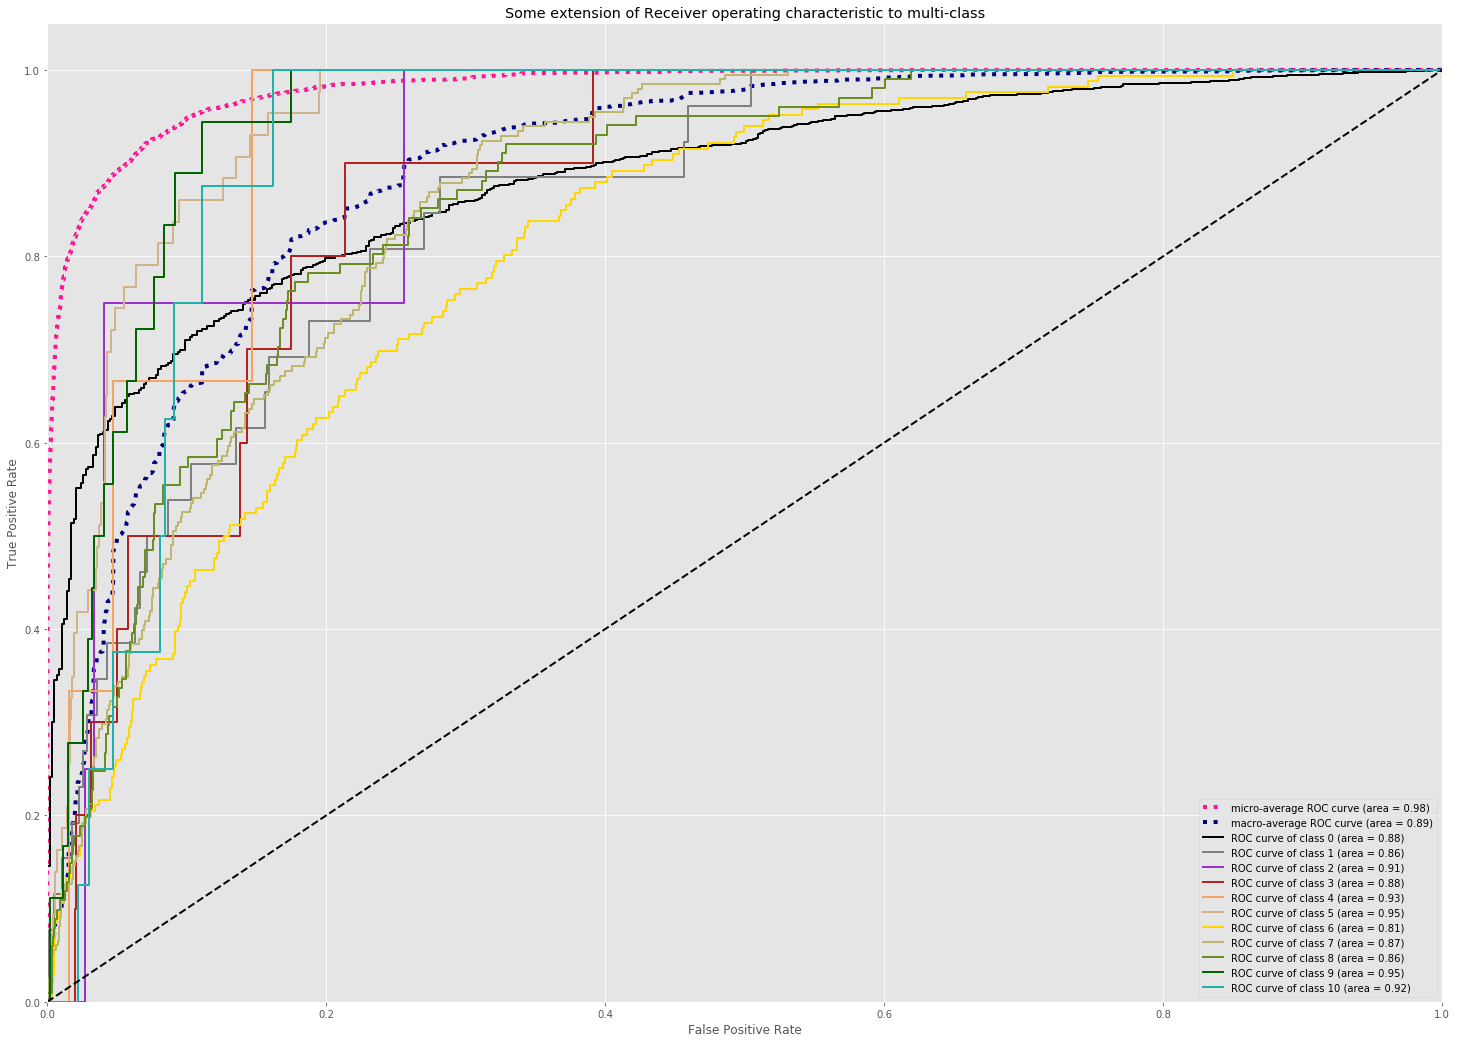

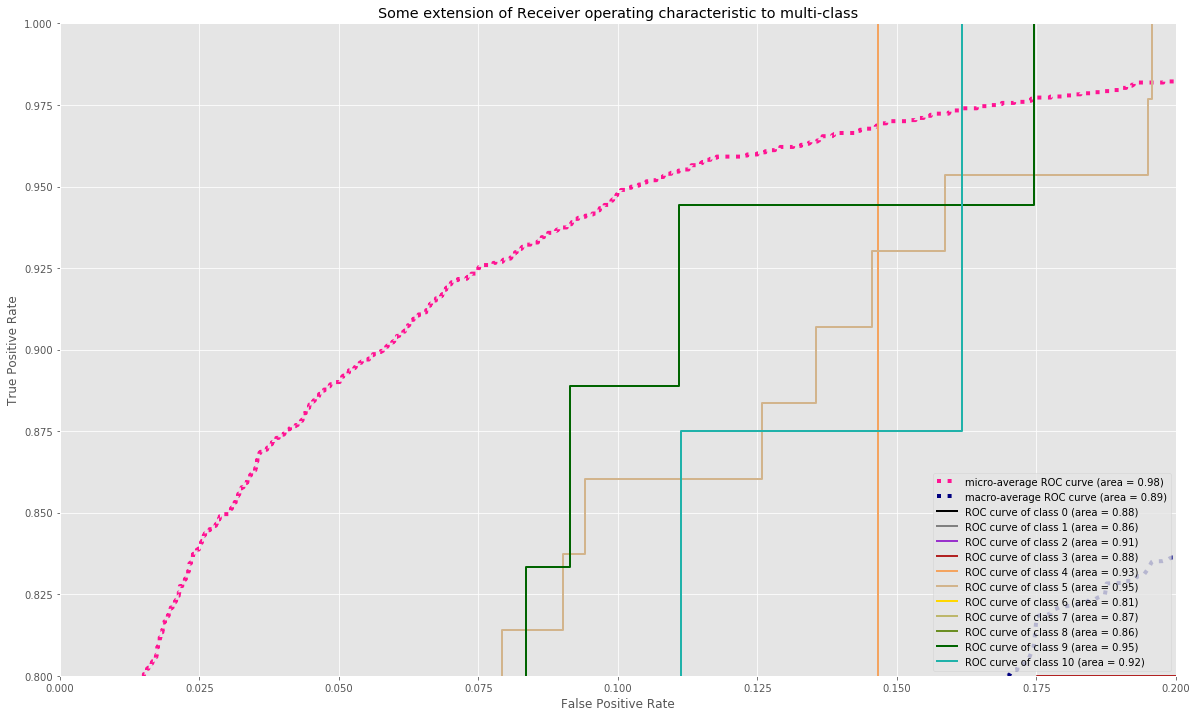

In [72]:
y_test=np.array(pd.get_dummies(y_valid))
y_score=DL_ML_result

lw = 2
n_classes=11

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1,figsize=(25,18))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['black','gray','darkorchid','firebrick','sandybrown','tan','gold','darkkhaki','olivedrab','darkgreen','lightseagreen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2,figsize=(20,12))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['black','gray','darkorchid','firebrick','sandybrown','tan','gold','darkkhaki','olivedrab','darkgreen','lightseagreen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Lift 수정 필요

### 2. LIFT
  - baseline : 0.11223946784922395

In [73]:
len_top20=np.int(np.round(len(DL_ML_result)*0.2))

ensemble_top20=pd.DataFrame(DL_ML_result).apply(lambda x: max(x), axis=1).sort_values(ascending=False)[:len_top20]
ensemble_pred20=np.array(pd.DataFrame(DL_ML_result).iloc[ensemble_top20.index]).argmax(axis=1)

In [74]:
lift_score=0
for i in range(11):
    lift_score+=(len(ensemble_pred20[ensemble_pred20==i])/len(ensemble_pred20))/(len(label['MRC_ID_DI'][label['MRC_ID_DI']==i])/len(label['MRC_ID_DI']))
lift_score/label['MRC_ID_DI'].nunique()

0.11223946784922395

### 3. final_score

# 마케팅
  1. 오프라인 고객의 성향을 파악해서 온라인 유입 전략
  2. 기존 온라인 유저들 장기 고객화
  
가. 데이터의 분포에 따른 중요 변수 선정 + 나. 상관계수에 따른 중요 변수 선정 + 다. 변수 중요도에 의한 중요 변수 선정 > 3가지의 교집합

## 가. 데이터의 분포에 따른 중요 변수 선정

## 1. 카테고리형 파악

In [75]:
train_cat=train[train.columns[train.dtypes=='int64'][1:]]
train_cat

,VAR007,VAR015,VAR018,VAR026,VAR059,VAR066,VAR067,VAR070,VAR071,VAR077,VAR078,VAR094,VAR096,VAR097,VAR098,VAR107,VAR111,VAR124,VAR127,VAR143,VAR144,VAR145,VAR148,VAR165,VAR177,VAR179,VAR199,VAR208,MRC_ID_DI
0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,8
2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,5
4,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10119,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,7
10120,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
10121,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
10122,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


* 변수내에서 1의 합 상위 5개

* 온·오프라인 다른 변수 : VAR107, VAR179, VAR007, VAR208, VAR097(이거다), VAR096, VAR078(이거도)

In [76]:
topN_cat=[]
for i in range(11):
    topN_cat+=list(pd.DataFrame(train_cat[train_cat['MRC_ID_DI']==i].iloc[:,:-1].sum().sort_values(ascending=False)/len(label[label['MRC_ID_DI']==i])).index)
train_cat_rank=pd.DataFrame(np.array(topN_cat).reshape(-1,28)).T
train_cat_rank

,0,1,2,3,4,5,6,7,8,9,10
0,VAR067,VAR067,VAR067,VAR067,VAR067,VAR067,VAR067,VAR067,VAR067,VAR067,VAR067
1,VAR165,VAR165,VAR165,VAR165,VAR165,VAR165,VAR165,VAR165,VAR165,VAR165,VAR165
2,VAR015,VAR015,VAR127,VAR015,VAR015,VAR015,VAR015,VAR015,VAR015,VAR066,VAR015
3,VAR127,VAR124,VAR015,VAR066,VAR077,VAR066,VAR124,VAR066,VAR124,VAR015,VAR066
4,VAR066,VAR111,VAR179,VAR124,VAR059,VAR124,VAR111,VAR124,VAR066,VAR179,VAR127
5,VAR059,VAR179,VAR059,VAR096,VAR066,VAR208,VAR066,VAR127,VAR111,VAR059,VAR179
6,VAR124,VAR070,VAR066,VAR111,VAR124,VAR059,VAR127,VAR208,VAR127,VAR127,VAR097
7,VAR018,VAR127,VAR096,VAR179,VAR111,VAR111,VAR179,VAR111,VAR179,VAR124,VAR059
8,VAR070,VAR145,VAR097,VAR208,VAR179,VAR077,VAR059,VAR059,VAR177,VAR097,VAR111
9,VAR111,VAR097,VAR208,VAR127,VAR127,VAR179,VAR148,VAR018,VAR059,VAR094,VAR018


## 2. 수치형 데이터 평균으로 인기도 확인

In [77]:
train_num=train[train.columns[train.dtypes!='int64'][1:]]
train_num['MRC_ID_DI']=label['MRC_ID_DI']
train_num

C:\anaconda\envs\samsung_card\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,VAR003,VAR004,VAR005,VAR006,VAR008,VAR009,VAR010,VAR011,VAR012,VAR013,VAR014,VAR016,VAR017,VAR019,VAR020,VAR021,VAR022,VAR023,VAR024,VAR025,VAR027,VAR028,VAR029,VAR030,VAR031,VAR032,VAR033,VAR034,VAR035,VAR036,VAR037,VAR038,VAR039,VAR040,VAR041,VAR042,VAR043,VAR044,VAR045,VAR046,VAR047,VAR048,VAR049,VAR050,VAR051,VAR052,VAR053,VAR054,VAR055,VAR056,VAR057,VAR058,VAR060,VAR061,VAR062,VAR063,VAR064,VAR065,VAR068,VAR069,VAR072,VAR073,VAR074,VAR075,VAR076,VAR079,VAR080,VAR081,VAR082,VAR083,VAR084,VAR085,VAR086,VAR087,VAR088,VAR089,VAR090,VAR091,VAR092,VAR093,VAR095,VAR099,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR108,VAR109,VAR110,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR125,VAR126,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR146,VAR147,VAR149,VAR150,VAR151,VAR152,VAR153,VAR154,VAR155,VAR156,VAR157,VAR158,VAR159,VAR160,VAR161,VAR162,VAR163,VAR164,VAR166,VAR167,VAR168,VAR169,VAR170,VAR171,VAR172,VAR173,VAR174,VAR175,VAR176,var178,VAR180,VAR181,VAR182,VAR183,VAR184,VAR185,VAR186,VAR187,VAR188,VAR189,VAR190,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR200,VAR201,VAR202,VAR203,VAR204,VAR205,VAR206,VAR207,VAR209,VAR210,VAR211,VAR212,VAR213,VAR214,VAR215,VAR216,VAR217,VAR218,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227,MRC_ID_DI
0,0.5280,-0.13607,0.10945,0.06557,0.7702,-0.18965,0.1981,0.24149,0.32429,-0.18611,0.06960,0.0049,0.8085,-0.11899,0.03969,-0.16651,0.12037,-0.01715,-0.09941,-0.28878,-0.07481,-0.12742,0.14367,0.06725,0.7702,0.04138,-0.01619,-0.32429,0.11580,0.7179,0.16920,-0.08048,0.28126,-0.11289,-0.02092,0.5381,0.22047,0.17756,0.03794,-0.04432,-0.28743,-0.01164,0.26300,-0.15466,-0.08374,-0.12935,-0.24726,-0.32134,0.39311,-0.32813,0.35632,0.12739,-0.18338,-0.07717,0.4688,0.18707,-0.03818,-0.04869,-0.14361,0.20281,0.02536,-0.20705,0.03747,0.28517,-0.18100,-0.20069,0.23156,-0.18709,0.20059,0.04329,0.0025,0.13105,-0.00891,0.23236,0.10216,0.28202,0.0077,-0.09886,0.29902,-0.22713,-0.23064,0.06628,0.11613,0.0093,0.03583,0.3578,0.20585,1.0000,-0.29631,0.0008,0.26873,0.05674,0.02082,0.26616,-0.25601,0.16075,0.15089,0.7286,0.07524,-0.11761,-0.13649,0.16103,0.38476,0.18881,0.00524,0.29896,0.36885,0.05585,0.06960,0.0068,0.05439,-0.04895,0.22997,0.06607,-0.02500,-0.05500,0.0020,0.07158,-0.11915,-0.09522,0.11580,0.35606,-0.32429,0.19451,-0.22885,0.01926,-0.15068,0.13834,-0.16525,0.09025,0.01253,0.20219,0.31263,-0.17855,-0.20515,-0.18453,-0.21851,0.37549,-0.10744,0.13043,0.0013,-0.17485,0.18986,-0.07305,0.0069,-0.30157,-0.16382,0.28385,-0.14273,-0.27069,0.3766,0.06165,0.0021,-0.03891,0.04840,-0.14790,0.26533,-0.00426,0.14765,-0.13332,0.03077,0.23017,0.11764,0.5740,0.06403,0.06184,0.04242,-0.04322,0.0051,0.04523,0.07247,0.09631,-0.22864,0.07262,-0.08837,0.01070,0.06340,0.12424,0.20392,0.24685,0.01432,-0.00966,0.09746,-0.17616,-0.18956,-0.13676,-0.13279,-0.32829,0.19113,0.05449,0.09471,0.27091,0.01931,0.02938,0.17105,0.12537,0.22197,0
1,0.1347,-0.13541,0.17331,-0.19657,0.0616,-0.23104,0.4940,-0.39476,-0.38366,0.39329,0.17549,0.3130,0.6564,0.31544,0.03794,-0.30237,-0.34538,0.04368,0.04381,-0.19160,-0.09801,-0.04593,0.11228,0.11692,0.5661,0.19938,0.01259,-0.17976,0.20081,0.7454,0.24256,0.01363,-0.22807,0.06728,0.17312,0.5369,0.23387,0.04572,0.05406,-0.18782,-0.23752,-0.10148,-0.16942,0.02893,0.03702,0.04855,0.36531,0.24302,-0.30677,-0.20810,-0.12376,0.15054,0.22430,0.10513,0.3797,-0.16796,0.01456,-0.10743,-0.08246,-0.38202,0.02066,0.28113,0.05687,-0.11689,0.16837,-0.08043,0.21618,-0.20256,0.23597,0.06233,0.3285,0.05898,0.00544,-0.29231,0.02483,-0.38122,0.0065,0.39975,0.09775,-0.34015,0.24286,0.10304,0.73571,0.7809,0.03591,0.2265,0.11679,0.0064,-0.33737,0.0064,0.32091,0.07577,0.13164,0.14677,0.26900,0.30351,-0.31481,0.8066,-0.23159,0.26470,-0.00125,0.27421,0.26218,-0.35553,0.18283,0.24857,-0.17245,0.08738,-0.13959,0.2398,0.08107,-0.21684,-0.40822,0.10503,-0.00399,0.03814,0.8007,-0.32165,0.28417,-0.2

### 온·오프라인 데이터 분포 확인 후 후보 변수 찾기 : 
var106, var147, var093, var128, var087, var184, var215, var218, var021, var056, var047, var034, var055, var025, var009, var141, var200, var004, var046, var081, var214, var133, var075, var185, var173, var130, var064, var222,var122, var157, var043, var115, var126, var153, var219, var187, var104, var149, var080, var226, var155

In [78]:
topN_num=[]
for i in range(11):
    topN_num+=list(pd.DataFrame(train_num[train_num['MRC_ID_DI']==i].iloc[:,:-1].sum().sort_values(ascending=False)/len(label[label['MRC_ID_DI']==i])).index)
train_num_rank=pd.DataFrame(np.array(topN_num).reshape(-1,197)).T
train_num_rank

,0,1,2,3,4,5,6,7,8,9,10
0,VAR003,VAR103,VAR138,VAR138,VAR010,VAR010,VAR010,VAR017,VAR010,VAR017,VAR010
1,VAR062,VAR031,VAR017,VAR010,VAR138,VAR138,VAR117,VAR010,VAR117,VAR010,VAR017
2,VAR036,var178,VAR010,VAR017,VAR117,VAR017,VAR017,VAR117,VAR138,VAR117,VAR117
3,VAR192,VAR192,VAR117,VAR117,VAR090,VAR117,VAR138,VAR103,VAR103,VAR031,VAR031
4,VAR008,VAR138,VAR103,VAR031,VAR017,VAR031,VAR103,VAR138,VAR017,VAR042,VAR036
5,VAR031,VAR117,VAR008,VAR008,var178,VAR103,VAR167,VAR031,VAR031,VAR036,VAR138
6,var178,VAR167,VAR167,VAR103,VAR167,VAR167,var178,VAR008,VAR167,var178,VAR042
7,VAR010,VAR010,VAR192,VAR042,VAR042,var178,VAR031,VAR042,var178,VAR103,var178
8,VAR103,VAR017,var178,VAR084,VAR031,VAR042,VAR008,VAR036,VAR042,VAR192,VAR103
9,VAR016,VAR008,VAR084,var178,VAR101,VAR008,VAR042,var178,VAR036,VAR167,VAR062


#### 후보 변수 인덱스 추출(num_top_index)
  - num_top_index는 각 class별로 num_top_list의 정렬된 순서대로 들어가있음

In [79]:
num_top_list=['VAR106', 'VAR147', 'VAR093', 'VAR128', 'VAR087', 'VAR184', 'VAR215', 'VAR218', 'VAR021', 'VAR056', 'VAR047', 'VAR034', 'VAR055', 'VAR025', 'VAR009', 'VAR141', 'VAR200', 'VAR004', 'VAR046', 'VAR081', 'VAR214', 'VAR133', 'VAR075', 'VAR185', 'VAR173', 'VAR130', 'VAR064', 'VAR222','VAR122', 'VAR157', 'VAR043', 'VAR115', 'VAR126', 'VAR153', 'VAR219', 'VAR187', 'VAR104', 'VAR149', 'VAR080', 'VAR226', 'VAR155']
num_top_list.sort()

In [80]:
np.array(num_top_list)

array(['VAR004', 'VAR009', 'VAR021', 'VAR025', 'VAR034', 'VAR043',
       'VAR046', 'VAR047', 'VAR055', 'VAR056', 'VAR064', 'VAR075',
       'VAR080', 'VAR081', 'VAR087', 'VAR093', 'VAR104', 'VAR106',
       'VAR115', 'VAR122', 'VAR126', 'VAR128', 'VAR130', 'VAR133',
       'VAR141', 'VAR147', 'VAR149', 'VAR153', 'VAR155', 'VAR157',
       'VAR173', 'VAR184', 'VAR185', 'VAR187', 'VAR200', 'VAR214',
       'VAR215', 'VAR218', 'VAR219', 'VAR222', 'VAR226'], dtype='<U6')

In [81]:
num_top_index=[]
for i in train_num_rank.columns:
    train_num_rank.sort_values(by=i, axis=0, inplace=True)
    df_test=pd.DataFrame(train_num_rank[0].apply(lambda x: True if x in num_top_list else False))
    num_top_index.append(df_test.index[df_test[0]].tolist())
num_top_index=np.array(num_top_index)

#### 추출한 인덱스로 값 획득(num_import_variable_value)
  - num_import_variable_value : 최종 값, shape(41,11) # 41 : 중요 후보 변수, 11 : class 갯수

In [82]:
topN_num2=[]
for i in range(11):
    topN_num2+=list(pd.DataFrame(train_num[train_num['MRC_ID_DI']==i].iloc[:,:-1].sum().sort_values(ascending=False)/len(label[label['MRC_ID_DI']==i])).values)
train_num_import_rank=pd.DataFrame(np.array(topN_num2).reshape(-1,197)).T
train_num_import_rank

,0,1,2,3,4,5,6,7,8,9,10
0,0.522545,0.667556,0.716407,0.769841,0.919582,0.718499,0.631051,0.706953,0.631076,0.716183,0.720582
1,0.506439,0.572681,0.697514,0.765469,0.864927,0.711569,0.618019,0.680793,0.629836,0.715208,0.716954
2,0.503569,0.571720,0.692179,0.732100,0.806582,0.699316,0.607397,0.679310,0.610373,0.691317,0.716018
3,0.503502,0.545793,0.682214,0.697984,0.767873,0.698455,0.593435,0.564575,0.599235,0.615985,0.583514
4,0.502712,0.529816,0.662857,0.619288,0.730227,0.565048,0.582039,0.558427,0.598337,0.512210,0.558475
5,0.499787,0.515944,0.608943,0.553081,0.631445,0.533807,0.577555,0.554851,0.574854,0.505069,0.539121
6,0.490404,0.514022,0.598071,0.545812,0.553382,0.532197,0.553760,0.521854,0.564201,0.466173,0.510929
7,0.487807,0.464105,0.583336,0.521497,0.537164,0.524189,0.531749,0.517266,0.554960,0.464081,0.509832
8,0.487772,0.463018,0.561343,0.508209,0.523636,0.520773,0.488517,0.511662,0.488809,0.443773,0.503943
9,0.473515,0.407564,0.549493,0.501503,0.500145,0.504878,0.487574,0.510713,0.444212,0.430873,0.491671


In [83]:
num_top_value=[]
count1=0
for i in range(len(num_top_list)):
    for i in train_num_import_rank.columns:
        num_top_value.append(train_num_import_rank[i].loc[num_top_index[:,count1][i]])
    count1+=1
num_import_variable_value=np.array(num_top_value).reshape(-1,11)

In [84]:
num_import_variable_value.shape

(41, 11)

#### 중요 후보군 변수(41개) 각 class별 값(num_import_variable_value) 비교
  - 43, 115(!), 122, 126, 130, 147, 155(!!), 157(!!) , 187, 222(!!!) , 226

C:\anaconda\envs\samsung_card\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


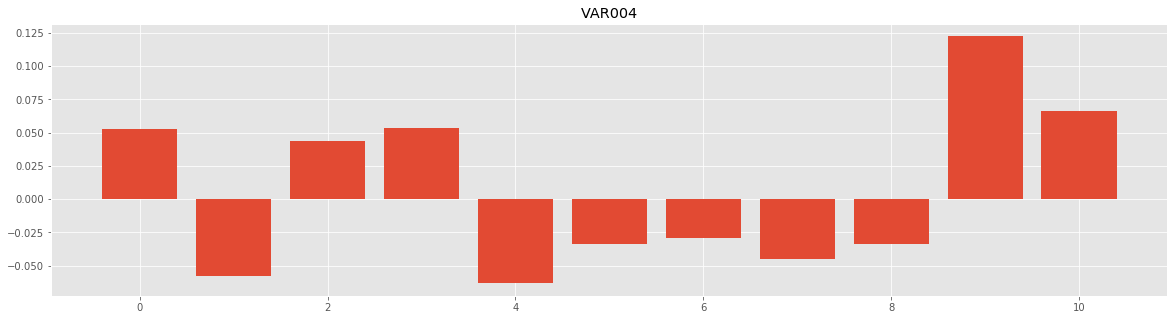

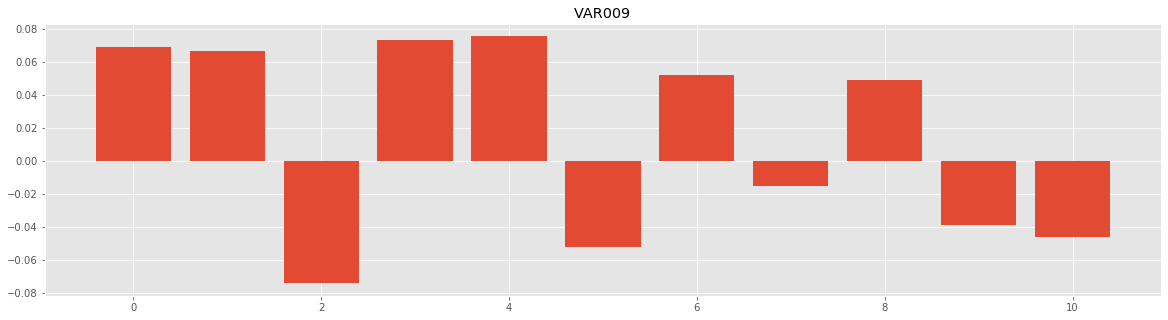

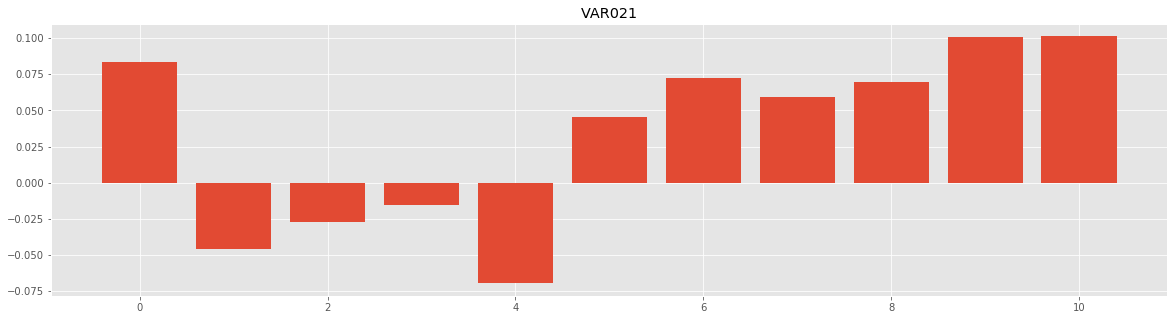

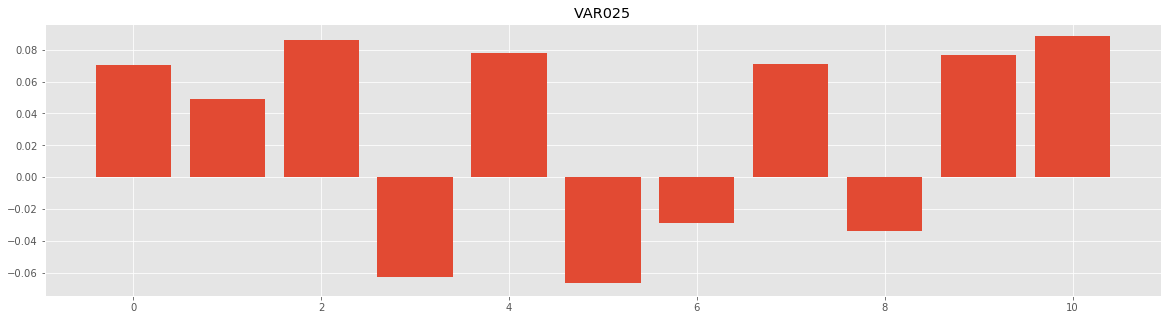

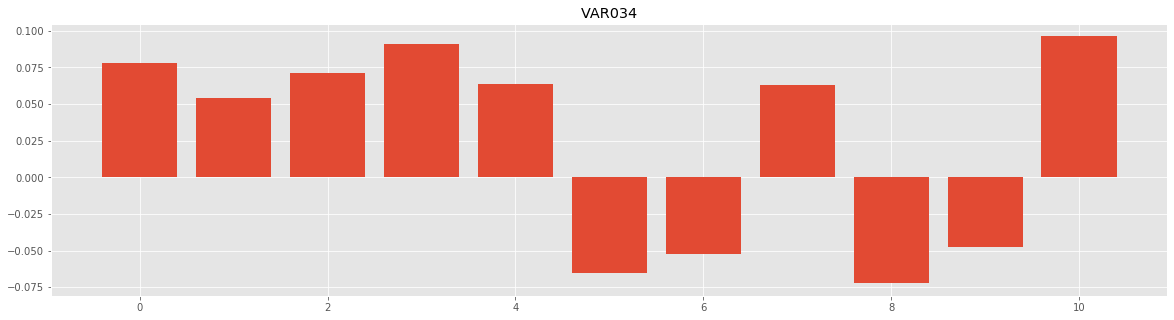

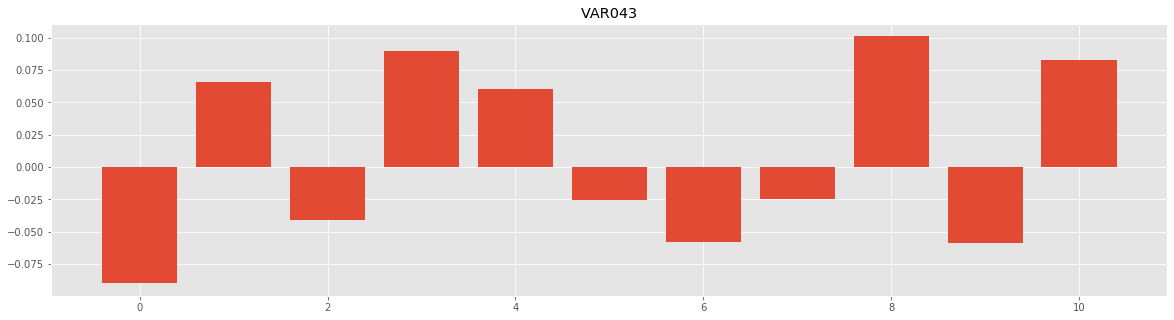

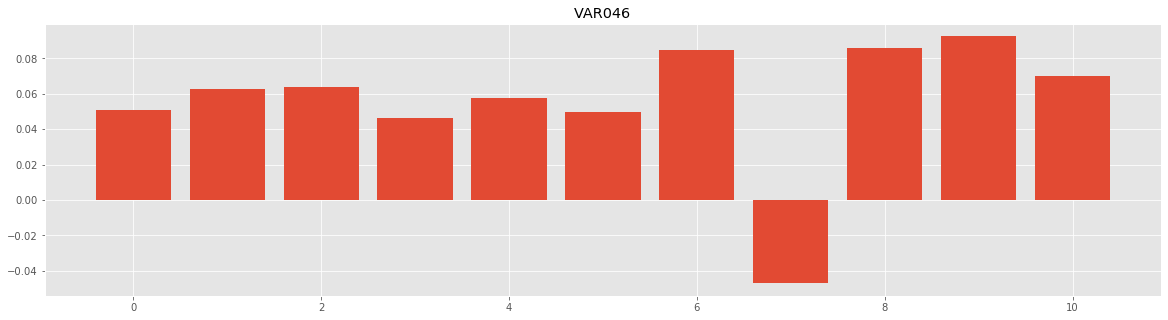

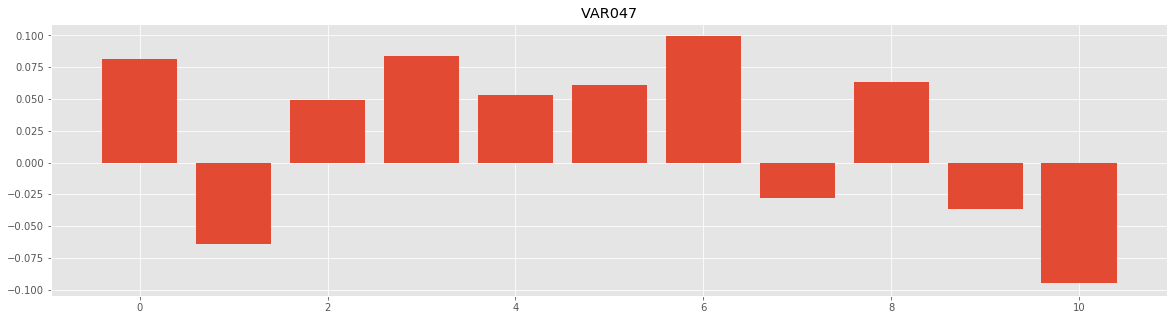

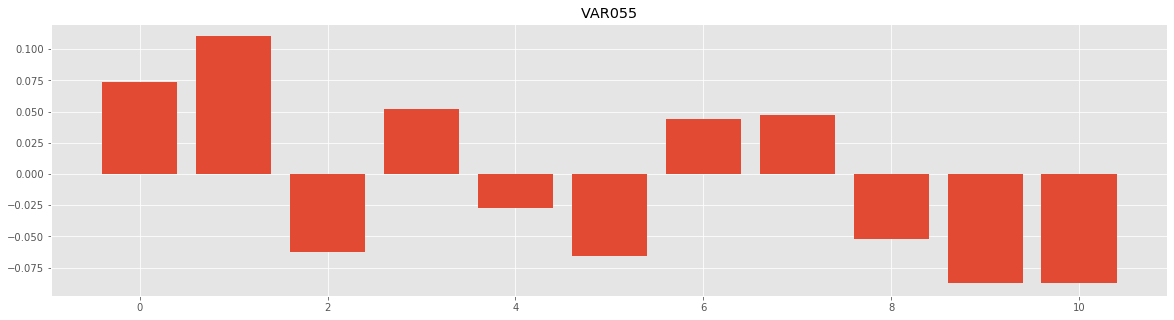

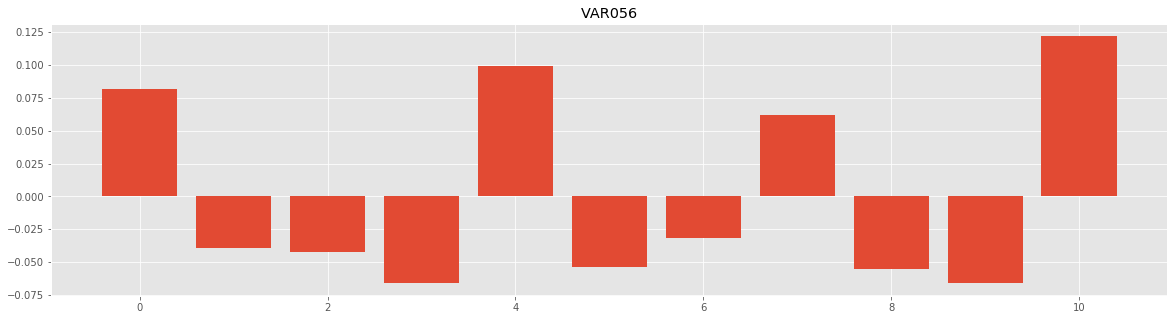

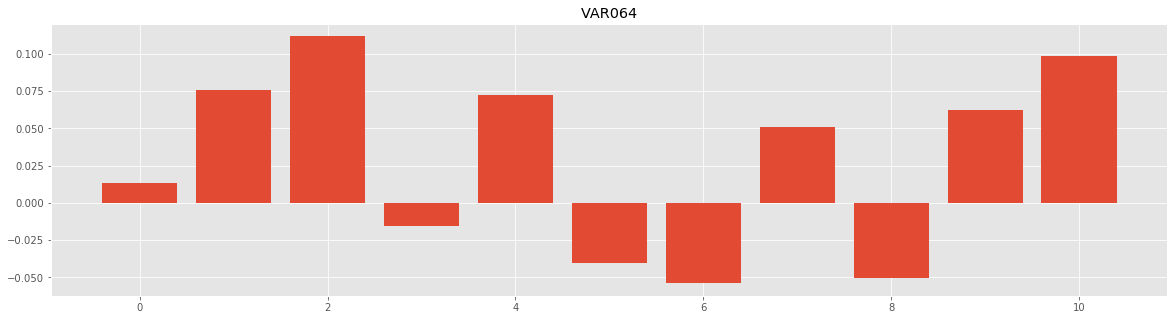

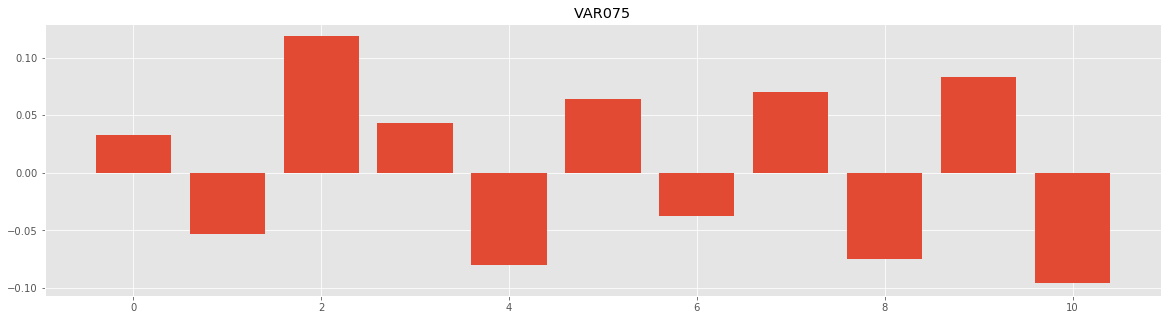

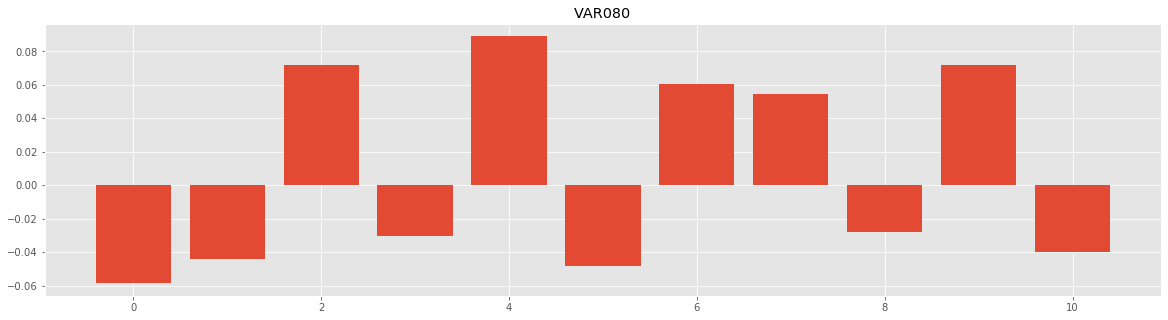

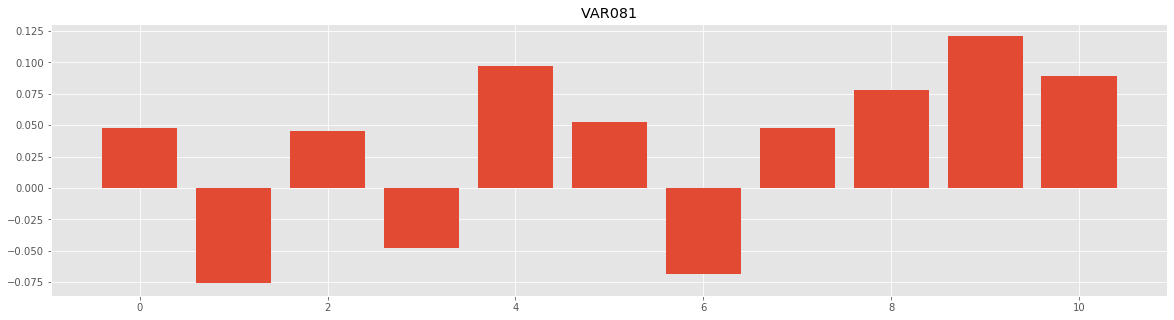

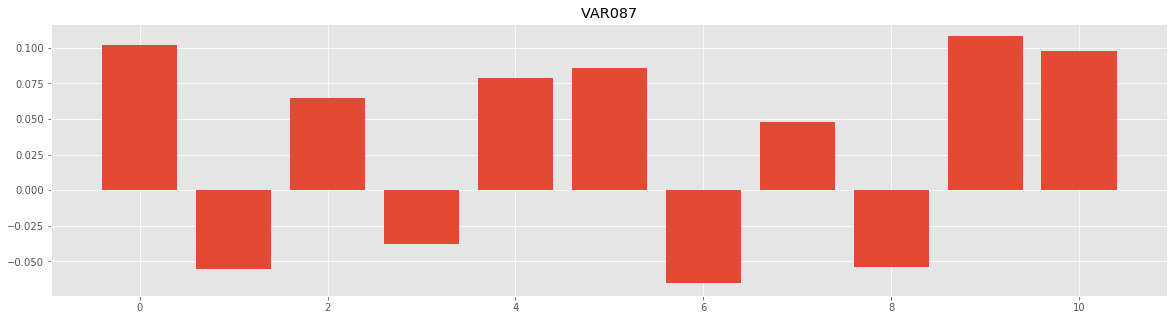

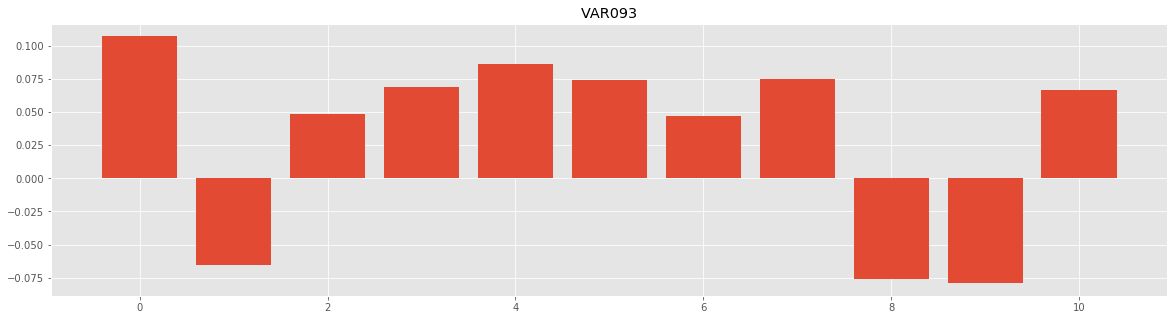

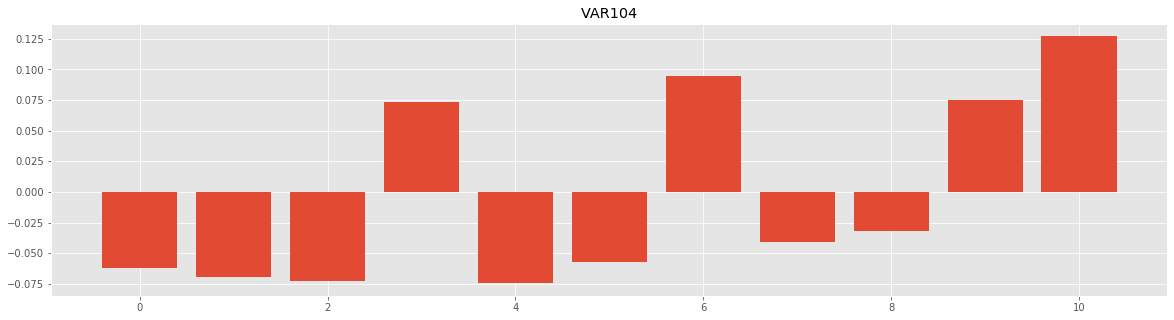

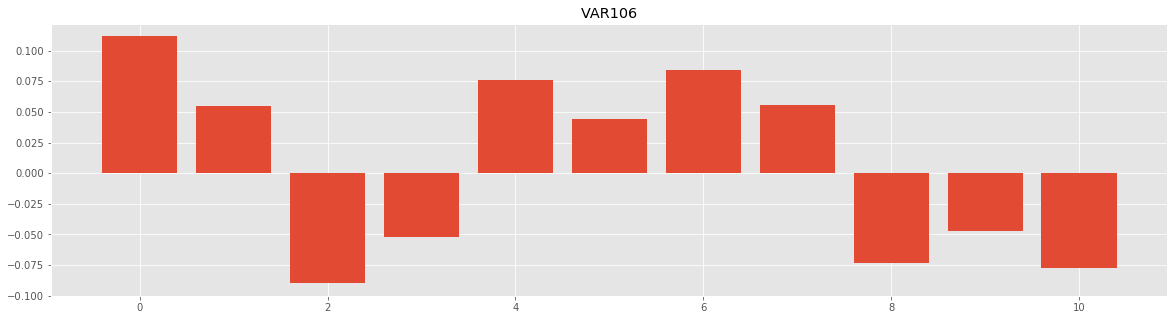

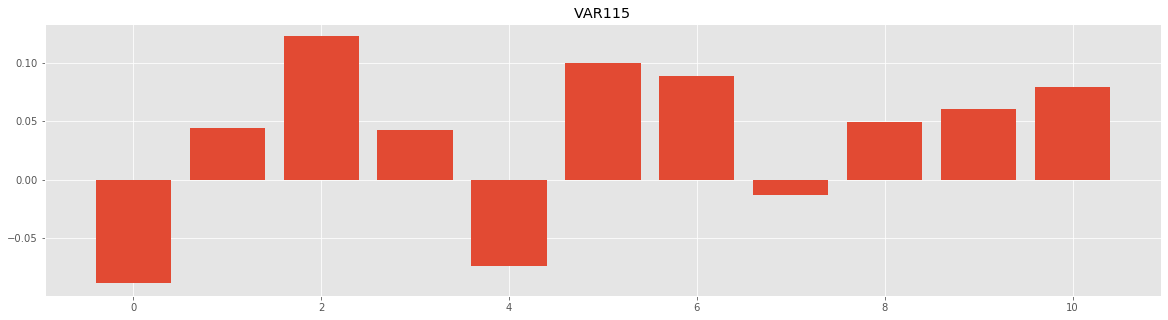

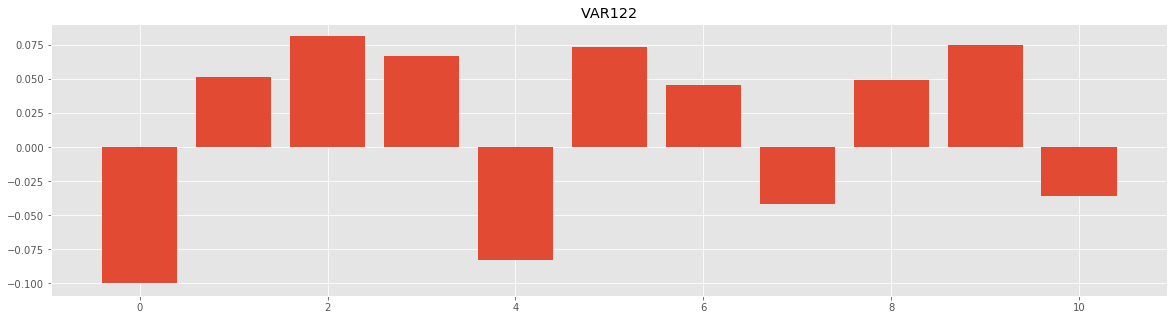

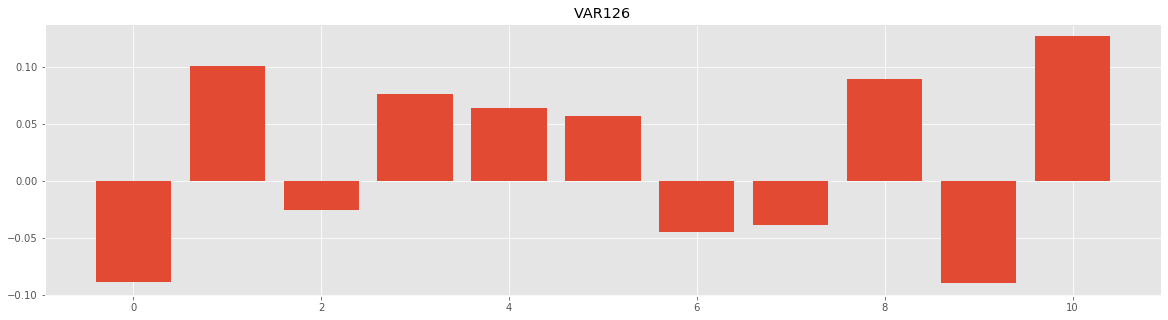

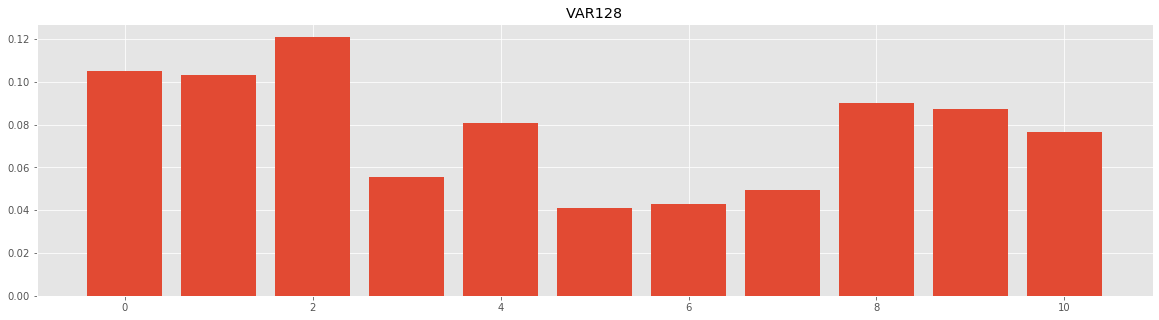

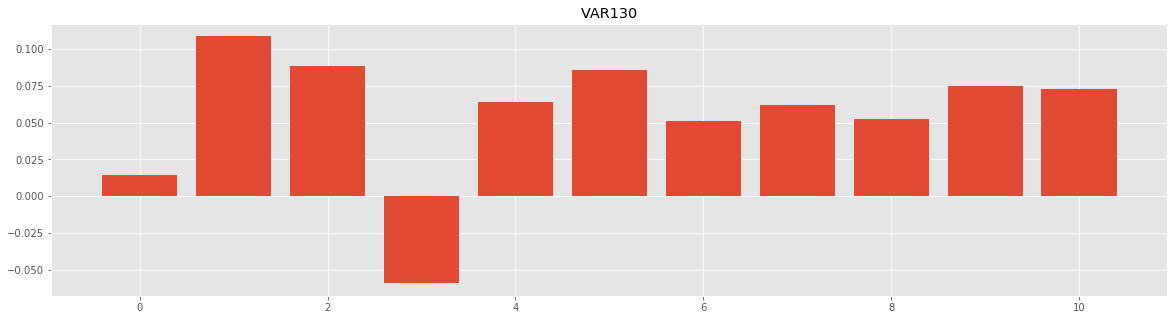

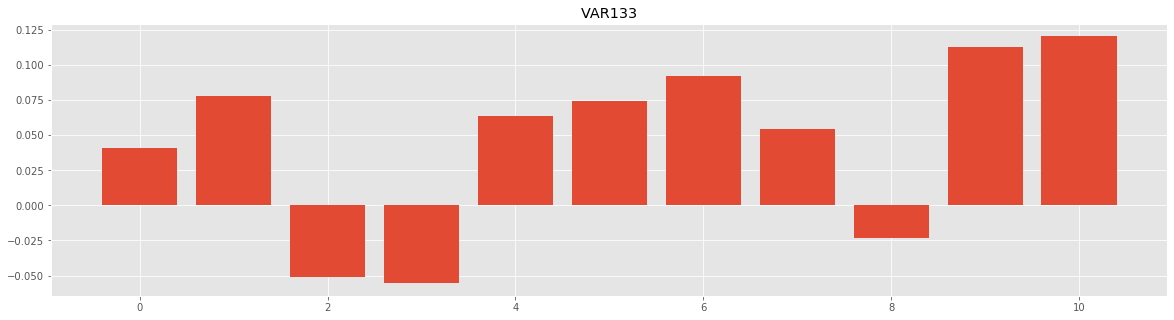

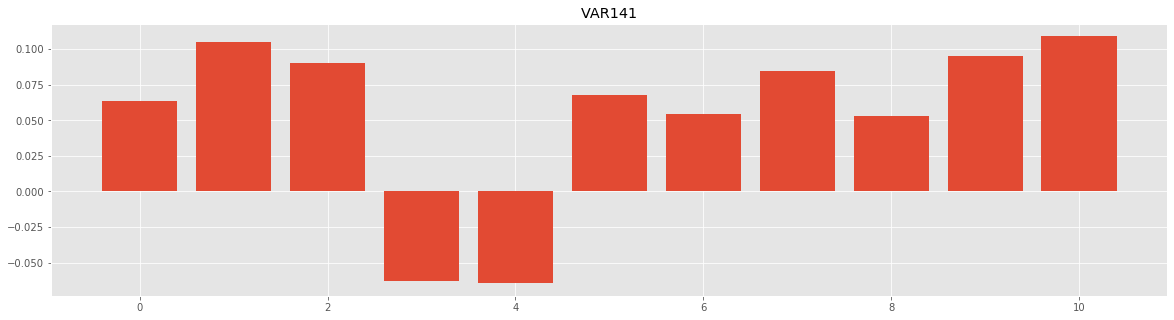

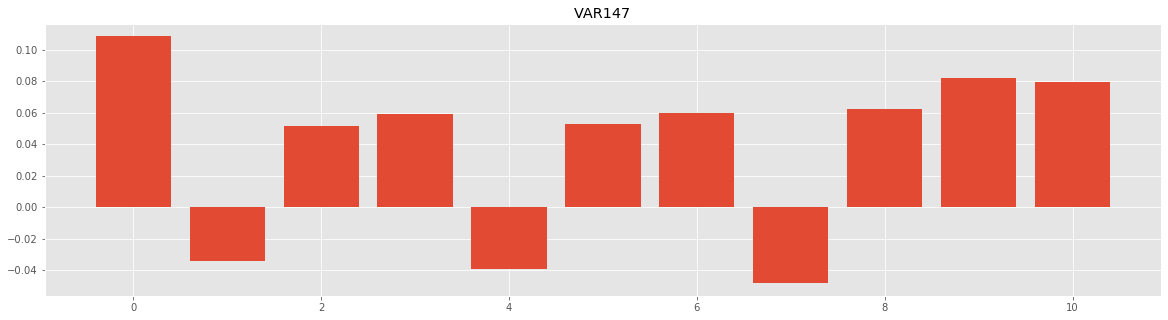

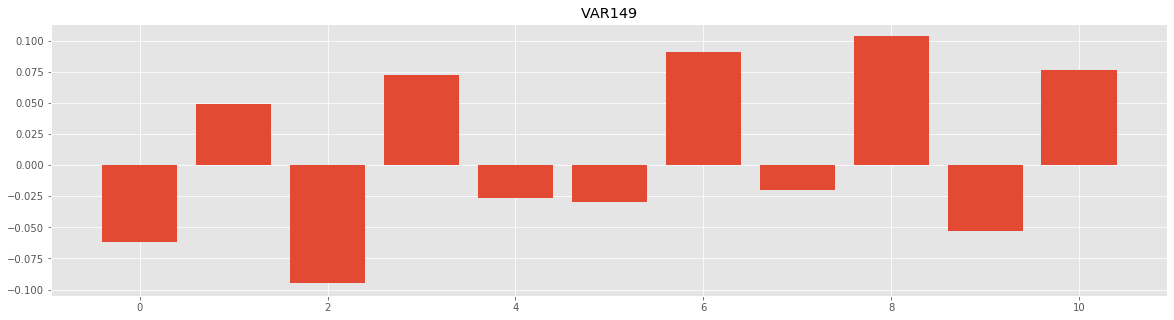

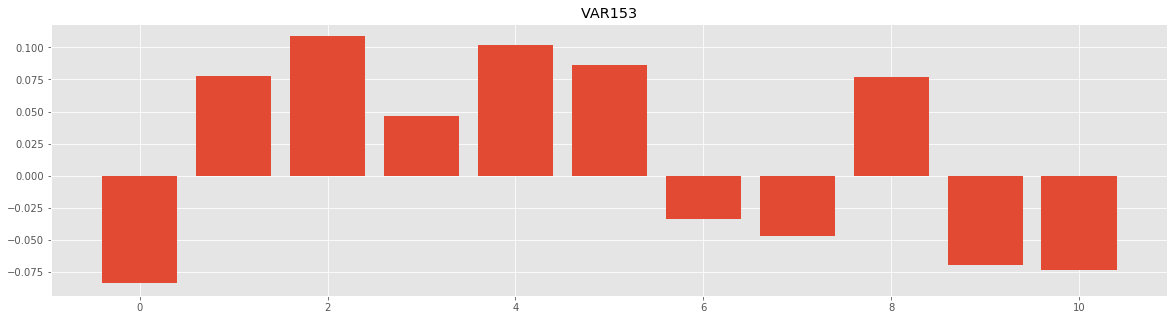

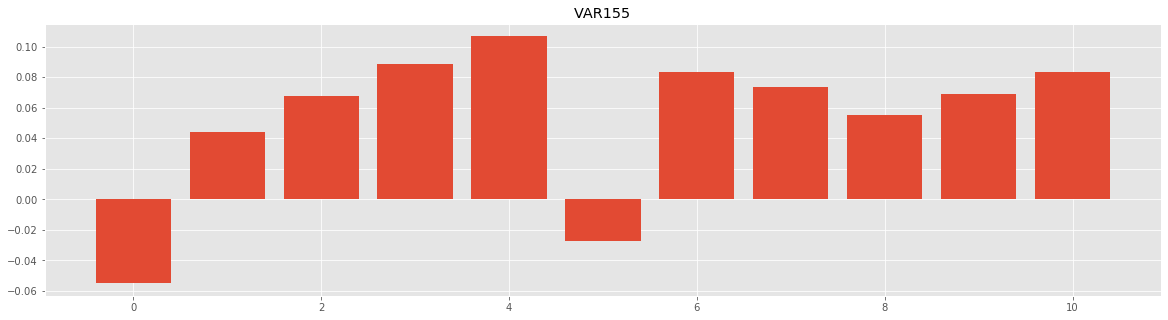

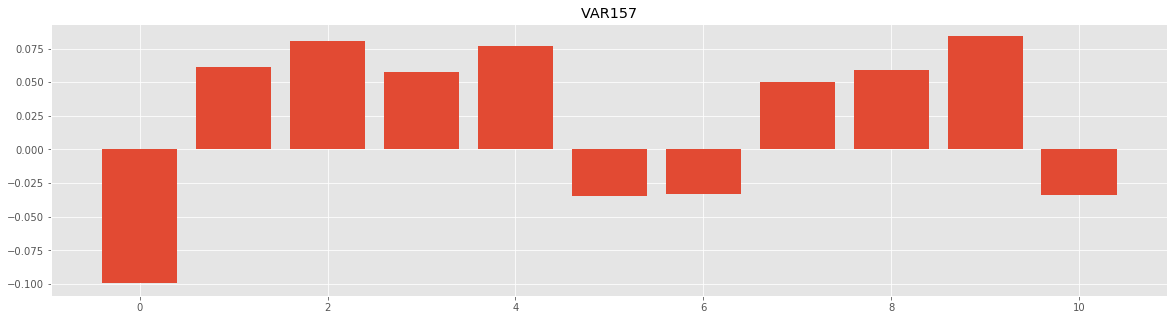

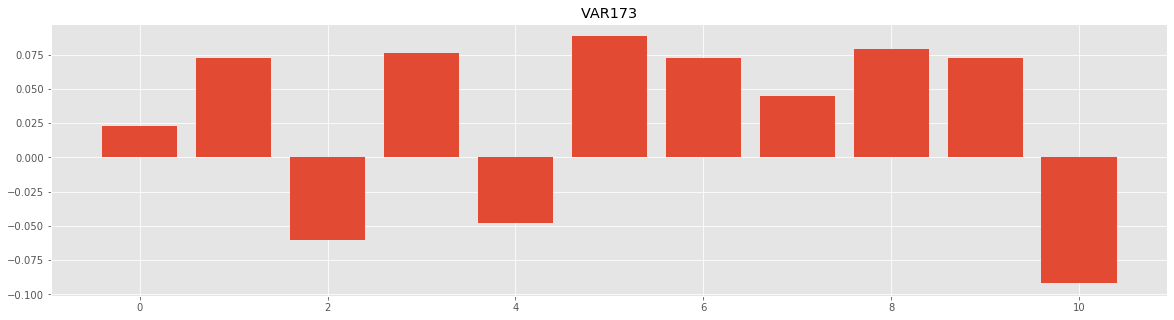

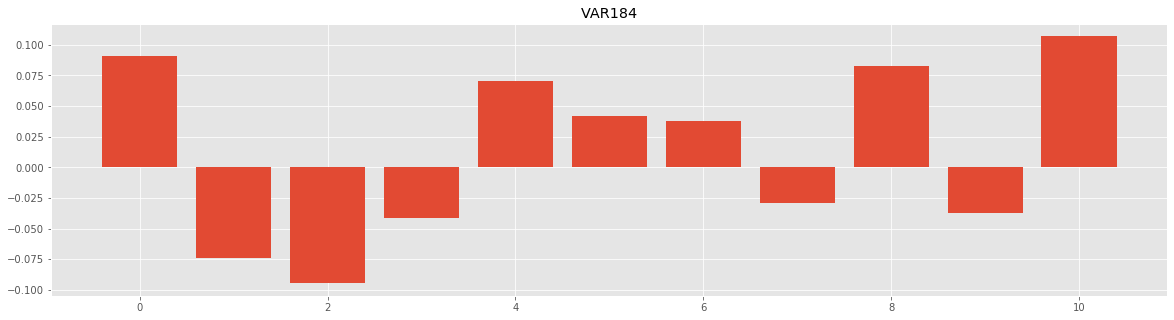

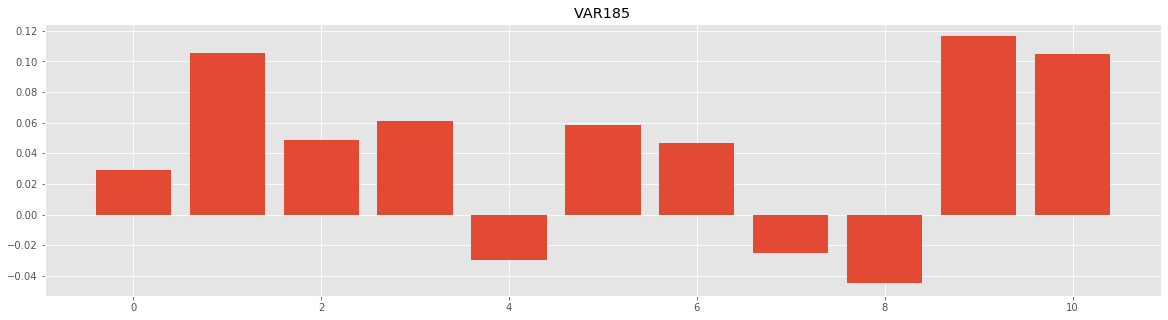

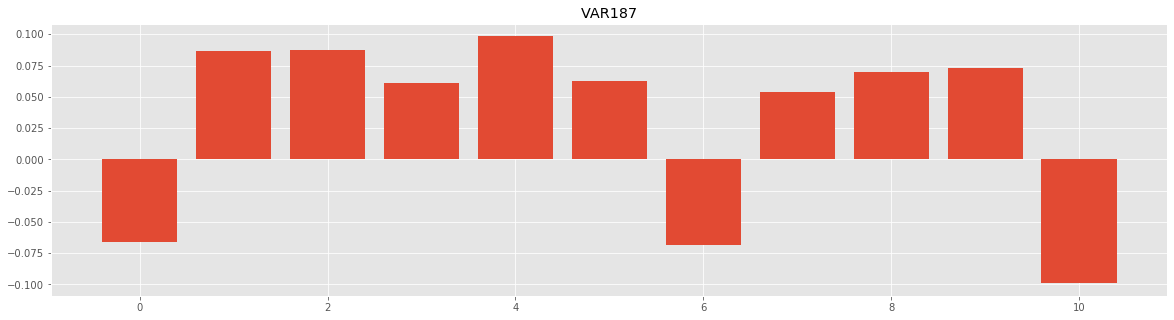

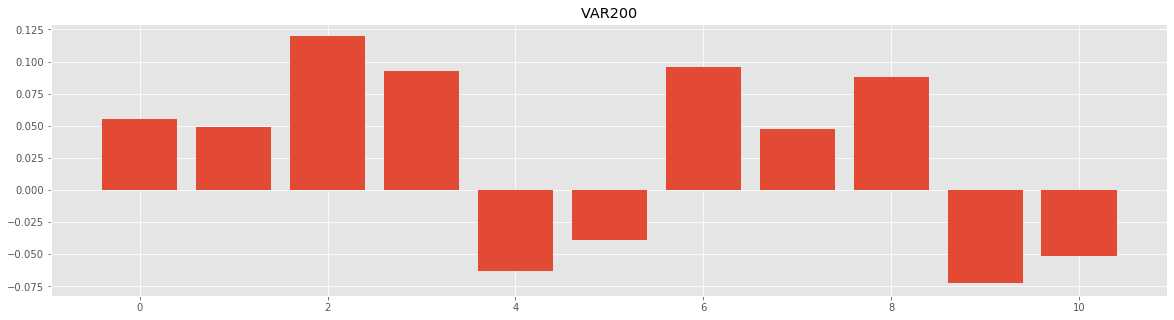

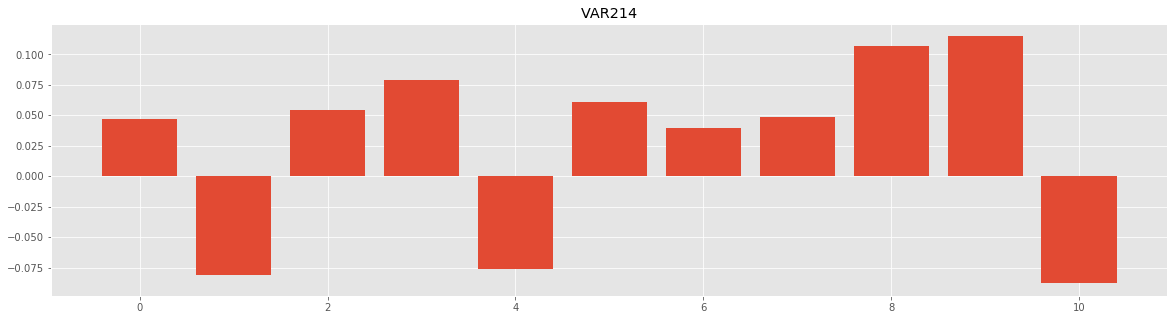

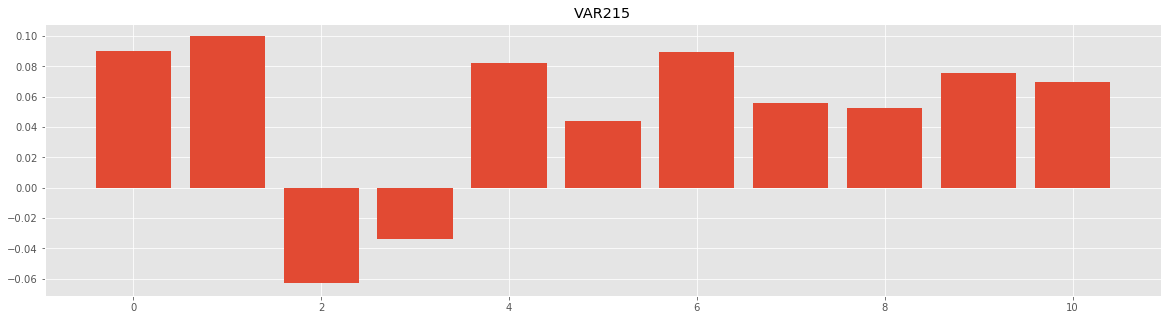

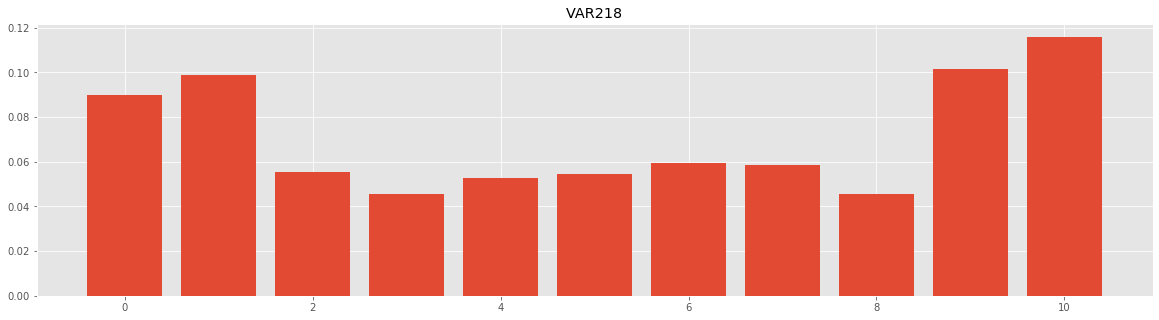

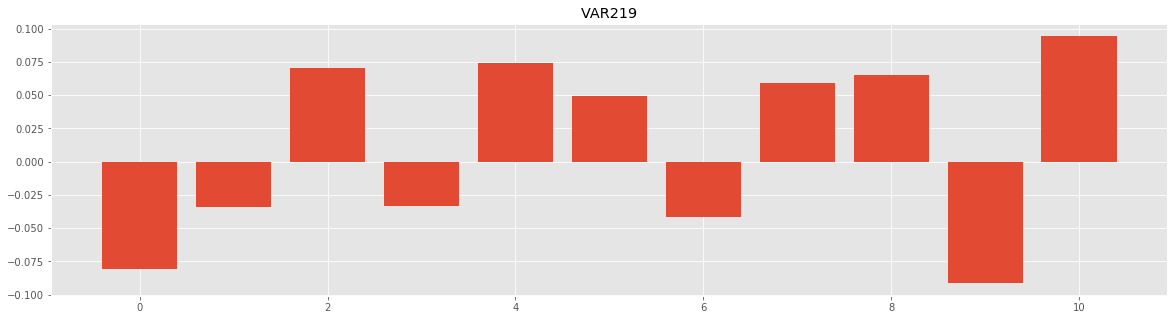

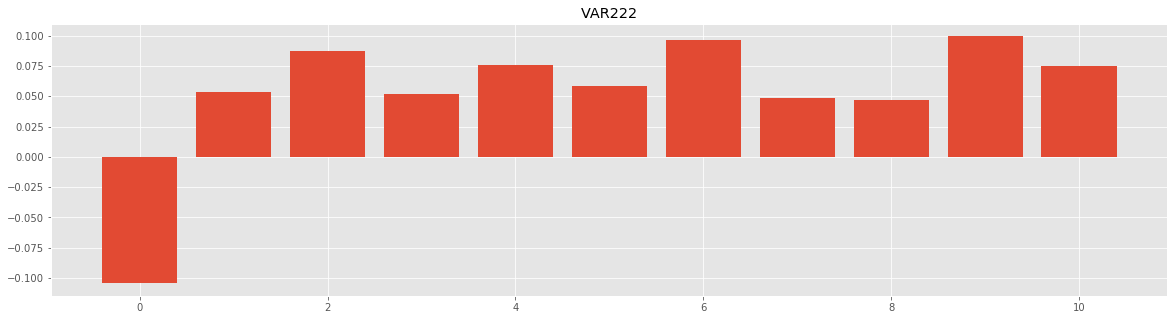

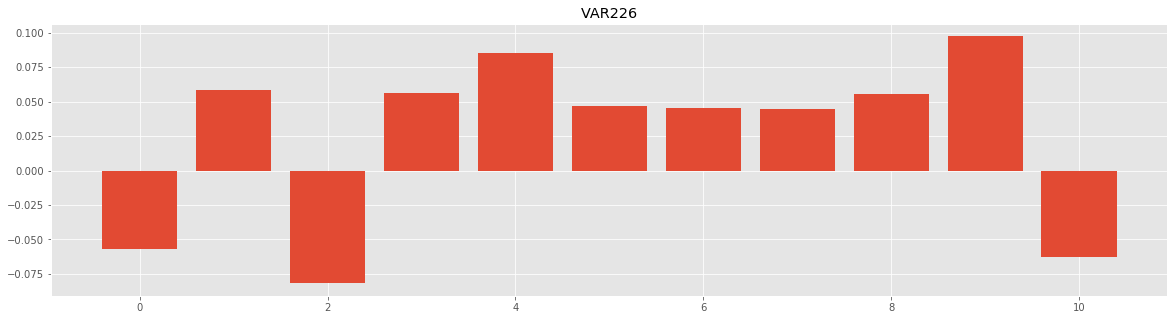

In [85]:
for i in range(len(num_top_list)):
    plt.figure(i,figsize=(20,5))
    plt.title(num_top_list[i])
    plt.bar(range(label['MRC_ID_DI'].nunique()),num_import_variable_value[i])

In [86]:
value_import=list(['VAR043','VAR115','VAR122','VAR126','VAR130','VAR147','VAR155','VAR157','VAR187','VAR222','VAR226','VAR107', 'VAR179', 'VAR007', 'VAR208', 'VAR097', 'VAR096', 'VAR078'])

#### 데이터의 분포에 따른 중요 변수 선정

## 2. 상관관계

- 목표변수 상관계수의 절댓값이 0.3 이상인 값 선정 > 42개

In [87]:
corr_import=train.corr()['MRC_ID_DI'][(train.corr()['MRC_ID_DI']>0.3) | (train.corr()['MRC_ID_DI']<-0.3)].index
corr_import=corr_import.drop(['MRC_ID_DI'])
print('상관계수 기준 중요 변수',corr_import, sep='\n')
print('상관계수 기준 중요 변수 갯수 :',len(corr_import))

상관계수 기준 중요 변수
Index(['VAR006', 'VAR012', 'VAR013', 'VAR021', 'VAR029', 'VAR034', 'VAR035',
       'VAR043', 'VAR046', 'VAR047', 'VAR051', 'VAR056', 'VAR069', 'VAR075',
       'VAR076', 'VAR080', 'VAR089', 'VAR093', 'VAR095', 'VAR104', 'VAR106',
       'VAR115', 'VAR116', 'VAR122', 'VAR123', 'VAR126', 'VAR133', 'VAR134',
       'VAR147', 'VAR150', 'VAR153', 'VAR157', 'VAR184', 'VAR187', 'VAR202',
       'VAR214', 'VAR215', 'VAR218', 'VAR219', 'VAR222', 'VAR226', 'VAR227'],
      dtype='object')
상관계수 기준 중요 변수 갯수 : 42


## 3. 변수 중요도
  - 평가지표의 점수가 높은 모델에 더 중점을 둠

1. catboost

In [88]:
pd.Series(cbc.feature_importances_,index=train2.iloc[:,:-1].columns).sort_values(ascending=False)

VAR138    3.383319
VAR040    2.085134
VAR226    1.976939
VAR214    1.947389
VAR065    1.922337
VAR104    1.871096
VAR003    1.791339
VAR217    1.545559
VAR042    1.505434
VAR048    1.474412
VAR050    1.416687
VAR103    1.388070
VAR101    1.360571
VAR108    1.347872
VAR024    1.286804
VAR008    1.284550
VAR075    1.236663
VAR161    1.203971
VAR192    1.159357
VAR079    1.154038
VAR210    1.112713
var178    1.102999
VAR046    1.092404
VAR025    1.085267
VAR010    1.032539
VAR136    1.008242
VAR062    0.985721
VAR133    0.911775
VAR090    0.892870
VAR031    0.884552
VAR105    0.863064
VAR055    0.812205
VAR041    0.812139
VAR187    0.804388
VAR152    0.794420
VAR117    0.788411
VAR212    0.777535
VAR211    0.768857
VAR022    0.766862
VAR201    0.765969
VAR197    0.761432
VAR131    0.751595
VAR181    0.746827
VAR027    0.738240
VAR064    0.721035
VAR171    0.719560
VAR183    0.714452
VAR205    0.709784
VAR195    0.666730
VAR140    0.664860
VAR084    0.658393
VAR149    0.655089
VAR120    0.

In [89]:
# train2.iloc[:,:-1].columns[pd.Series(cbc.feature_importances_,index=train2.iloc[:,:-1].columns).sort_values(ascending=False)>1]

In [90]:
cat_import=pd.Series(cbc.feature_importances_,index=train2.iloc[:,:-1].columns).sort_values(ascending=False)[:42].index

2. xgboost

In [91]:
pd.Series(xgb.feature_importances_,index=train2.columns).sort_values(ascending=False)

VAR104          0.037064
VAR226          0.021591
VAR021          0.009896
VAR153          0.009366
VAR210          0.009267
VAR138          0.009142
VAR214          0.008536
VAR161          0.008113
VAR115          0.007529
VAR025          0.007416
VAR160          0.007156
VAR167          0.007043
VAR075          0.007036
VAR157          0.006786
VAR034          0.006554
VAR043          0.006529
VAR147          0.006483
VAR097          0.006274
VAR051          0.006264
VAR035          0.006105
VAR095          0.006036
VAR106          0.006004
VAR003          0.005975
VAR118          0.005899
VAR100          0.005869
VAR128          0.005822
VAR027          0.005773
VAR057          0.005736
VAR110          0.005711
VAR018          0.005688
VAR065          0.005537
VAR012          0.005518
VAR105          0.005511
VAR040          0.005429
VAR216          0.005386
VAR024          0.005347
VAR050          0.005322
VAR123          0.005279
VAR177          0.005241
VAR169          0.005240


In [92]:
xgb_import=pd.Series(xgb.feature_importances_,index=train2.columns).sort_values(ascending=False)[:42].index

3. lgbm

In [93]:
pd.Series(lgbm.feature_importances_,index=train2.columns).sort_values(ascending=False)

VAR138          3092
VAR079          2030
VAR217          1913
VAR104          1909
VAR090          1612
VAR226          1558
VAR167          1546
VAR003          1543
VAR031          1527
VAR172          1466
VAR008          1442
VAR022          1438
VAR103          1437
VAR192          1423
VAR108          1390
VAR040          1385
VAR036          1385
VAR010          1384
VAR062          1381
VAR042          1379
VAR050          1342
VAR171          1339
VAR183          1321
VAR065          1306
VAR210          1297
VAR182          1294
VAR105          1271
VAR016          1252
VAR117          1239
VAR048          1238
VAR181          1200
VAR125          1197
VAR041          1157
VAR130          1152
VAR075          1145
var178          1132
VAR214          1124
VAR101          1121
VAR201          1098
VAR197          1080
VAR175          1062
VAR084          1056
VAR140          1031
VAR142          1018
VAR033          1014
VAR131          1011
VAR211          1008
VAR057       

In [94]:
lgbm_import=pd.Series(lgbm.feature_importances_,index=train2.columns).sort_values(ascending=False)[:42].index

4. random_forest

In [95]:
pd.Series(rf.feature_importances_,index=train2.columns).sort_values(ascending=False)

VAR226          0.042595
VAR138          0.035876
VAR021          0.034943
VAR104          0.033380
VAR046          0.032678
VAR115          0.029303
VAR214          0.028783
VAR157          0.025344
VAR133          0.023578
VAR047          0.020531
VAR051          0.020186
VAR095          0.017884
VAR056          0.017168
corr_top_sum    0.016895
VAR153          0.016694
VAR089          0.013657
VAR106          0.010403
VAR219          0.010385
VAR217          0.010369
VAR134          0.009908
VAR025          0.009830
VAR227          0.009604
VAR075          0.008828
VAR222          0.008818
VAR012          0.008535
VAR041          0.008148
VAR210          0.007730
VAR027          0.006992
VAR126          0.006960
VAR122          0.006865
VAR123          0.006763
VAR024          0.006688
VAR164          0.006638
VAR076          0.006383
VAR161          0.006271
VAR029          0.006219
VAR034          0.006156
VAR167          0.006052
VAR172          0.005758
VAR080          0.005695


In [100]:
rf_import=pd.Series(rf.feature_importances_,index=train2.columns).sort_values(ascending=False)[:42].index

In [101]:
set(corr_import) & set(cat_import) & set(xgb_import) & set(lgbm_import) & set(rf_import)

{'VAR075', 'VAR104', 'VAR214', 'VAR226'}

# 결론
  - 온라인 vs 오프라인 : value_import 3개
  - 온라인 10개와 오프라인 1개 : 교집합 4개

In [74]:
set(value_import)

{'VAR007',
 'VAR043',
 'VAR078',
 'VAR096',
 'VAR097',
 'VAR107',
 'VAR115',
 'VAR122',
 'VAR126',
 'VAR130',
 'VAR147',
 'VAR155',
 'VAR157',
 'VAR179',
 'VAR187',
 'VAR208',
 'VAR222',
 'VAR226'}

In [75]:
set(corr_import) & set(cat_import) & set(xgb_import) & set(lgbm_import)

{'VAR075', 'VAR104', 'VAR214', 'VAR226'}